# Machine learning capstone project - fx spot prediction

The goal is to create features that can help predict the bid price, using a lookback period of a few minutes.

Try to include the bid offer spread - from the benchmark model it seems volume is not an important feature so it is not a problem that i dont have this data point.

I took inspiration from : https://www.kaggle.com/kimy07/eurusd-15-minute-interval-price-prediction/notebook

Introduction
This notebook trains a LSTM model that predicts the bid price of EURUSD 15 minutes in the future by looking at last five hours of data. While there is no requirement for the input to be contiguous, it's been empirically observed that having the contiguous input does improve the accuracy of the model. I suspect that having day of the week and hour of the day as the features mitigates some of the seasonality and contiguousness problems.

Disclaimer: This exercise has been carried out using a small sample data which only contains 14880 samples (2015-12-29 00:00:00 to 2016-05-31 23:45:00) and lacks ASK prices. Which restricts the ability for the model to approach a better accuracy.

I will use 1 year of data, from 1Jan16 to 1Jan17, also in 15 minute intervals, but with tick data features.

Improvements

To tune the model further, I would recommend having at least 5 years worth of data, have ASK price (so that you can compute the spread), and increasing the epoch to 3000.
Adding more cross-axial features. Such as spread.
If you are looking into classification approach (PASS, BUY, SELL), consider adding some technical indicators that is more sensitive to more recent data.
Consider adding non-numerical data, e.g. news, Tweets. The catch is that you have to get the data under one minute for trading, otherwise the news will be reflected before you even make a trade. If anybody knows how to get the news streamed really fast, please let me know.

Credits : Dave Y. Kim, Mahmoud Elsaftawy,

To run on EC2:
- Enter the repo directory: cd aind2-cnn
- Activate the new environment: source activate aind2
- Start Jupyter: jupyter notebook --ip=0.0.0.0 --no-browser
- Find this line in output and copy url to browser: 
- Copy/paste this URL into your browser when you connect for the first time to login with a token: http://0.0.0.0:8888/?token=3156e...
- change the 0.0.0.0 with EC2 IP.
- you should see the checked out repository

In [1]:
import pandas as pd, numpy as np
import pypyodbc
import io, datetime, os, dill
import matplotlib.colors as colors, matplotlib.cm as cm, pylab, matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from subprocess import check_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
import pypyodbc
display(HTML("""<script>
  
    $('.ctb_hideshow').css({'display': 'block'});
    
    </script>
 """))

In [3]:
initval = True

In [4]:
#kaggle dates: 2015-12-29 00:00:00 to 2016-05-31 23:45:00
min_date = "29Dec15"
max_date = "31May16"

if initval:
    rerunSQL = False
    log = True
    useKaggle = False
    runLSTMBinary = False
    simname = "bm_with_lookback_5_epochs_500"
    sim_desc = """
    kaggle params with my dataset
    """

In [5]:
import subprocess
def df_to_image(df, imgpath, filename):
    #dfplot.style.background_gradient(cmap='viridis', low=.5)

    #np.random.seed(123)
    #df = pd.DataFrame(np.random.randn(10, 5), columns=list('abcde'))


    # def hover(hover_color="#ffff99"):
    #     return dict(selector="tr:hover",
    #                 props=[("background-color", "%s" % hover_color)])

    # styles = [
    #     hover(),
    #     dict(selector="th", props=[("font-size", "150%"),
    #                                ("text-align", "center")]),
    #     dict(selector="caption", props=[("caption-side", "bottom")])
    # ]
    # html = (dfplot.style.set_table_styles(styles)
    #           .set_caption("Hover to highlight."))



    # #html = dfplot.style.render()
    # html = html.render()


    HEADER = """
    <html>
        <head>
            <style>
                .df tbody tr:nth-child(even) { background-color: #f5f5f5; }
            </style>
        </head>
        <body>
    """
    FOOTER = """
        </body>
    </html>
    """


    # dfplot.to_html('report graphs/simlog.html'
    #                , classes=['rendered_html', 'output_html', 'output_result'])
    with open(imgpath+filename+'.html', 'w') as f:
         f.write(HEADER)
         f.write(df.to_html(classes=['df', 'rendered_html']))
         f.write(FOOTER)
    return subprocess.call(
         'wkhtmltoimage -f png --width 800 "'+imgpath+filename+'.html" "'+imgpath+filename+'.png"', shell=True)

# Load data

In [6]:
if log:
    #log = {"simname": ["mine_initial", simname], "sim_desc": ["kaggle params", sim_desc]}
    #df_log = pd.DataFrame(log)
    if os.path.isfile("sim_log.xlsx"):
        df_log = pd.read_excel("sim_log.xlsx")
        df_log.loc[len(df_log)]= [simname, sim_desc] 
        df_log.to_excel("sim_log.xlsx")

In [7]:
display(pd.read_excel("sim_log.xlsx"))
display(pd.read_excel("log_results.xlsx").T)


,simname,sim_desc
0,dummy,dummy
1,kaggle_bm,\n kaggle params\n
2,kaggle param my dataset,\n kaggle params with my dataset\n
3,bm_with_lookback_5_epochs_500,\n kaggle params with my dataset\n
4,bm_with_lookback_5_epochs_500,\n kaggle params with my dataset\n
5,bm_with_lookback_5_epochs_500,\n kaggle params with my dataset\n
6,bm_with_lookback_5_epochs_500,\n kaggle params with my dataset\n
7,bm_with_lookback_5_epochs_500,\n kaggle params with my dataset\n
8,bm_with_lookback_5_epochs_500,\n kaggle params with my dataset\n


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
simname,kaggle linear regression,bm_kaggle,kaggle param my dataset linear regression,kaggle param my dataset,kaggle param my dataset linear regression,kaggle param my dataset,bm_with_lookback_10,bm_with_lookback_2,bm_with_lookback_30,bm_with_lookback_60,bm_with_lookback_5,bm_with_lookback_5_batch_100,bm_with_lookback_5_batch_1000,bm_with_lookback_5_epochs_500,bm_with_lookback_5_epochs_1000,bm_with_lookback_5_epochs_500,bm_with_lookback_5_epochs_500,bm_with_lookback_5_epochs_500,bm_with_lookback_5_epochs_500,bm_with_lookback_5_epochs_500
sim_desc,kaggle 1 row lookback,kaggle bm has 200 epoch and batch size 500 and...,\n kaggle params with my dataset\n 1 ro...,kaggle bm has 200 epoch and batch size 500 and...,\n kaggle params with my dataset\n 1 ro...,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n
MSE,7.78252e-06,1.20446e-07,6.54157e-08,2.45924e-07,9.72119e-08,5.59631e-07,2.63716e-07,5.11102e-07,3.56223e-07,3.40443e-07,1.9192e-07,2.50884e-07,4.70728e-07,1.3067e-07,3.05962e-07,3.4891e-07,1.31174e-07,2.15744e-07,0.00170677,4.07329e-07
MAE,0.00233305,0.000278994,0.000202497,0.000429252,0.000228927,0.000571841,0.000391006,0.000586614,0.000425628,0.000417161,0.000348615,0.000401295,0.000571145,0.000272417,0.000450971,0.000467292,0.00027801,0.000354073,0.0412842,0.000492958
count,149,149,103,102,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149
mean,0.00230515,9.99558e-05,-2.86507e-05,0.000327489,9.69676e-06,-0.000226223,0.000291342,0.0004673,0.000211435,4.8595e-05,-0.000185057,0.000349894,-0.000443419,-8.11183e-06,0.000421663,0.000381116,-4.8155e-05,0.000262991,-0.0412842,-0.000218943
std,0.00157654,0.000333468,0.000255398,0.00037423,0.000312688,0.000715464,0.000424316,0.000542872,0.00056002,0.000583409,0.000398422,0.000359619,0.000525319,0.000362611,0.000359204,0.00045281,0.000360175,0.000384149,0.00154687,0.000601516
min,-0.00105977,-0.00100839,-0.000780582,-0.000641942,-0.000779629,-0.0018394,-0.000664353,-0.00124609,-0.00115061,-0.00137413,-0.00126648,-0.000430465,-0.00178719,-0.000883698,-0.000402927,-0.00069344,-0.00086534,-0.000657678,-0.04354,-0.00172734
25%,0.000746131,-0.00011158,-0.000195682,0.000149757,-0.000189185,-0.000689983,2.43187e-05,0.000217319,-0.0001086,-0.000298381,-0.000445724,0.000124812,-0.000771403,-0.000214458,0.00016892,0.000154614,-0.000270247,6.19888e-06,-0.0424299,-0.000597596
50%,0.00332856,0.000176191,-2.80142e-05,0.000362039,-7.27177e-06,-0.000272751,0.0002352,0.000464559,0.000171542,-4.79221e-05,-0.000210404,0.000325561,-0.000485659,-4.82798e-05,0.000408173,0.000347495,-8.53539e-05,0.000258803,-0.04193,-0.000188231


In [8]:
# create 15 minute data - this fills the 15 minutes table
if rerunSQL:
    str_query = open("get_data.sql", "r").read() # returns prepared data
    str_query = str_query.replace("/*", "").replace("*/", "")

    df = getQueryDataframe(str_query, [min_date, max_date])

In [9]:
# dates only have an effect if a subset of dates is needed.
if rerunSQL:
    str_query = open("get_data_1y.sql", "r").read() # returns prepared data
    str_query = str_query.replace("/*", "").replace("*/", "")
    #print(str_query)
    df = getQueryDataframe(str_query, [min_date, max_date])
    df.head()

In [10]:
if rerunSQL:
    df.set_index('datestamp', inplace=True)
    df.index = pd.to_datetime(df.index) # else fill betweeen doesnt work
    print("min date", min(df.index))
    print("max date", max(df.index))

In [11]:
if rerunSQL:
    df.to_csv("data/eurusd_features.csv")

# Load data from file and create features

In [12]:
df = pd.read_csv("data/eurusd_features.csv")
df.set_index('datestamp', inplace=True)
df.index = pd.to_datetime(df.index) # else fill betweeen doesnt work

In [13]:
useKaggle=False
if useKaggle:
    # load kaggle reference dataset for comparison
    df_kaggle = pd.read_csv('data/bm_kaggle/EURUSD_15m_BID_sample.csv')
    #df_kaggle = pd.read_csv('data/bm_kaggle/EURUSD_15m_BID_01.01.2010-31.12.2016.csv')

    # Rename bid OHLC columns
    df_kaggle.rename(columns={'Time' : 'date', 'Open' : 'open_bid', 'Close' : 'close_bid', 
                       'High' : 'high_bid', 'Low' : 'low_bid', 'Volume' : 'volume'}, inplace=True)
    df_kaggle['date'] = pd.to_datetime(df_kaggle['date'], infer_datetime_format=True)
    df_kaggle.set_index('date', inplace=True)
    df_kaggle = df_kaggle.astype(float)

    simname = "bm_kaggle"

    df = df_kaggle
    print("min date", min(df.index))
    print("max date", max(df.index))

In [14]:
df.count()

year                           10204
month                          10204
day                            10204
hour                           10204
weekday                        10204
15_min                         10204
high_bid                       10204
low_bid                        10204
avg_bo_spread                  10204
nb_ticks                       10204
open_bid                       10204
close_bid                      10204
last_10_tick_avg_bid_return    10204
last_10_tick_avg_bo_spread     10204
dtype: int64

In [15]:
# to include seasonality as a feature
if useKaggle:
    df['hour'] = df.index.hour
    df['day']  = df.index.weekday
    df['week'] = df.index.week
    df['month'] = df.index.month
    df['momentum']  = df['volume'] * (df['open_bid'] - df['close_bid'])
    
df['avg_price'] = (df['low_bid'] + df['high_bid'])/2
df['range']     = df['high_bid'] - df['low_bid']
df['ohlc_price'] = (df['low_bid'] + df['high_bid'] + df['open_bid'] + df['close_bid'])/4
df['oc_diff']    = df['open_bid'] - df['close_bid']
if useKaggle==False:
    df['period_return'] = df.close_bid / df.open_bid

# Explore dataset - show some graphs

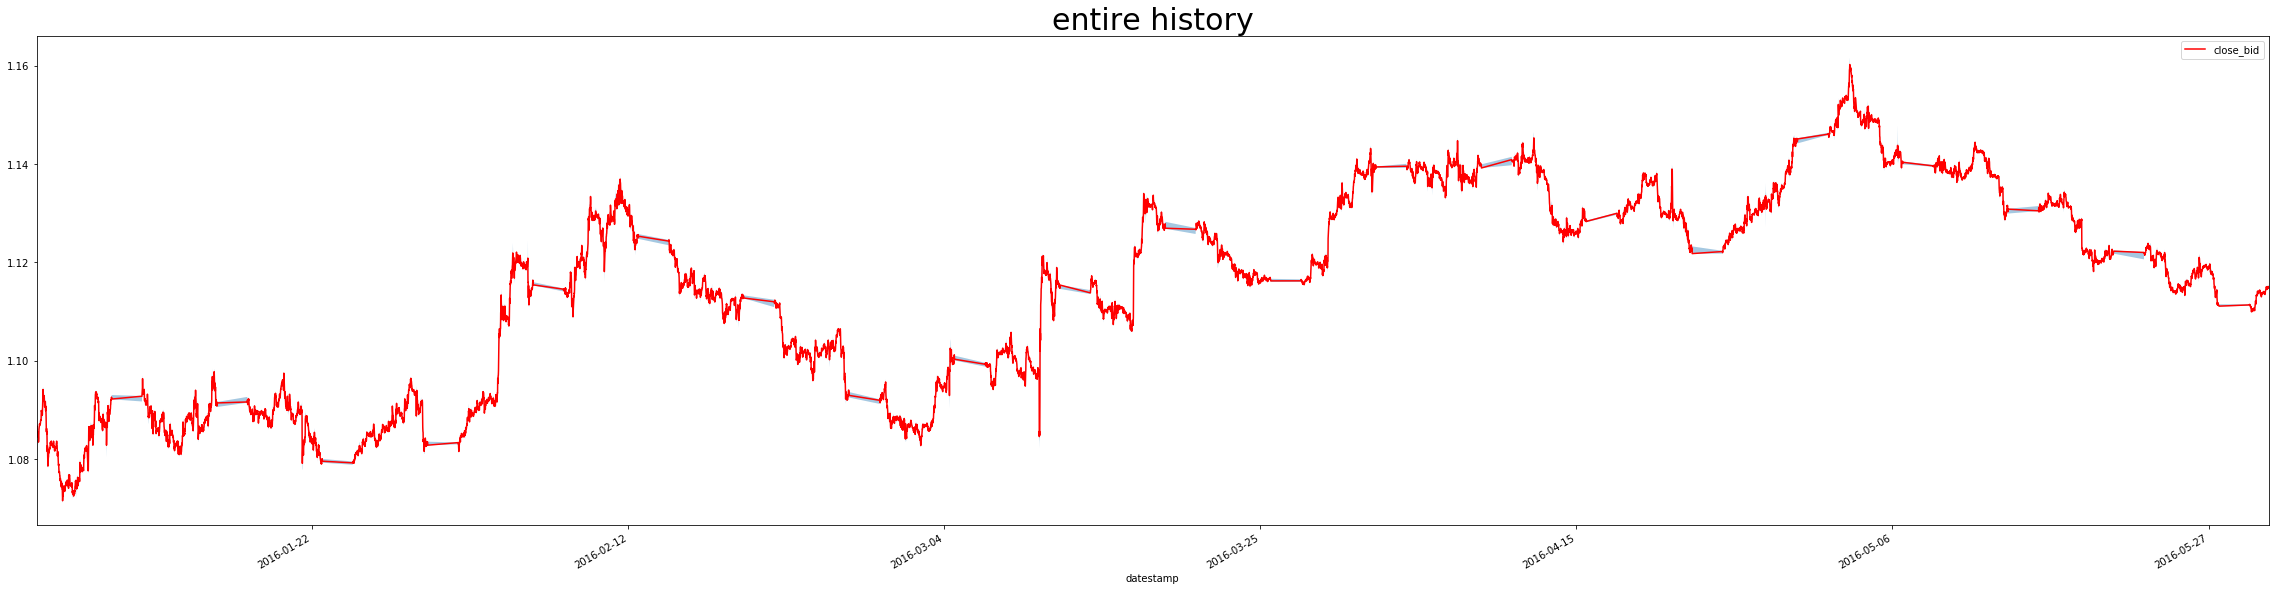

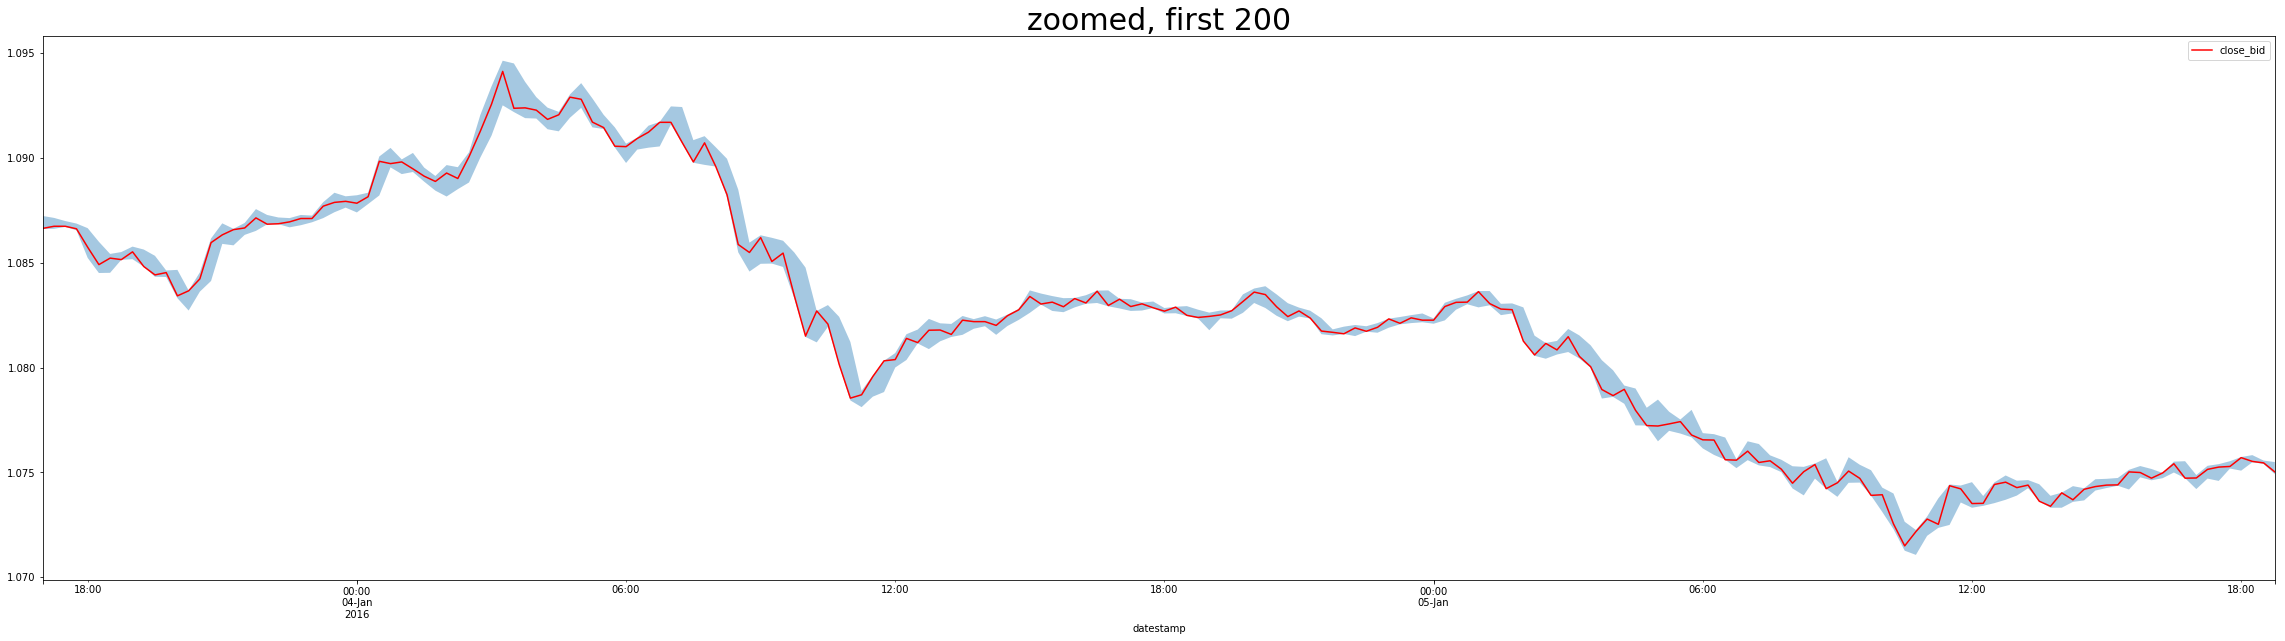

In [16]:
# plot close price, compare to low and high price
ax = df.plot(x=df.index, y='close_bid', c='red', figsize=(40,10))
index = [str(item) for item in df.index]
plt.fill_between(x=index, y1='low_bid',y2='high_bid', data=df, alpha=0.4)
plt.title("entire history", fontsize=30)
title="bidhistory"
plt.savefig("report graphs/"+title+"_fig.png")
plt.show()

# plot first 200 entries 
p = df[:200].copy()
ax = p.plot(x=p.index, y='close_bid', c='red', figsize=(40,10))
index = [str(item) for item in p.index]
plt.fill_between(x=index, y1='low_bid', y2='high_bid', data=p, alpha=0.4)
plt.title('zoomed, first 200', fontsize=30)
plt.show()

- there are periods where the price doesnt move, probably weekends. Maybe dont consider these for training

In [17]:
def pltGraph(xname, yname, irow, icol, df, xval=None, yval=None, title=None, norm_axis=None):
    x_axis_col = xname
    y_axis_col = yname
    if xval is None:
        xval = df[x_axis_col]
    if yval is None:
        yval = df[y_axis_col]
    if title is None:
        title = x_axis_col + " vs " + y_axis_col
    if norm_axis is None:
        norm_axis = "x"
  
    #print("before plot:", (title, irow, icol))
    axarr[irow, icol].scatter(xval.values, yval.values, color="green", lw=0, cmap=pylab.cm.cool, alpha=0.8, s=2)
    axarr[irow, icol].set_xlim(xval.values.min(), xval.values.max())
    axarr[irow, icol].set_ylim(yval.values.min(), yval.values.max())
    axarr[irow, icol].set_xlabel(x_axis_col)
    axarr[irow, icol].set_ylabel(yname)
    axarr[irow, icol].set_title(title)
    axarr[irow, icol].grid(False)
    
    irow,icol=get_next_irow_icol(irow,icol,axarr)
    
    return irow, icol

In [18]:
def get_next_irow_icol(irow, icol, axarr):
    try:
        if (irow+1 > axarr.shape[0]-1) and (icol+1 > axarr.shape[1]-1):

            raise ValueError("need more rows")

        if icol+1 > axarr.shape[1]-1:
            icol = 0
            irow +=1
        else:
            icol +=1
    except:
        pass
        # create new plot
        #fig,axarr = plt.subplots(2,2)
        
    return irow, icol

In [19]:
import datetime
datetime.datetime.now().time().strftime("%H%M%S")

'130409'

In [20]:
def get_new_plot_and_plot_prev(title=None):
    
    
    plt.savefig("report graphs/"+title+"_fig.png")
    
    fig, axarr = plt.subplots(2, 2, figsize=(10,10)) #1 row, 2 cols, x, y
    irow, icol = 0,0
    return fig, axarr, irow, icol

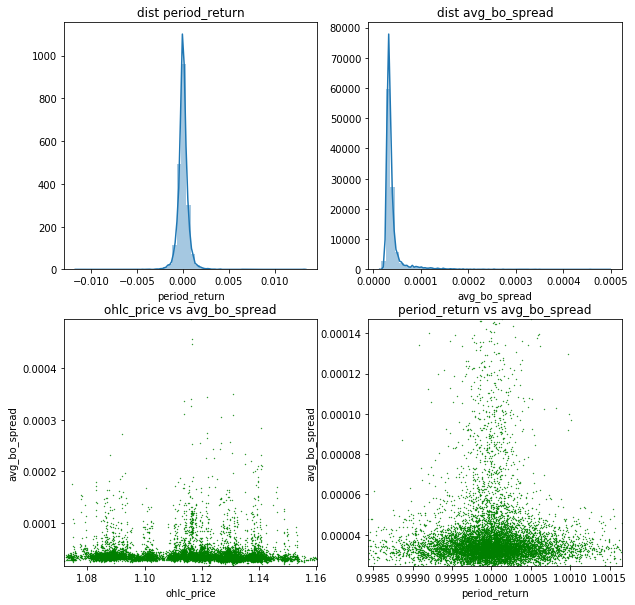

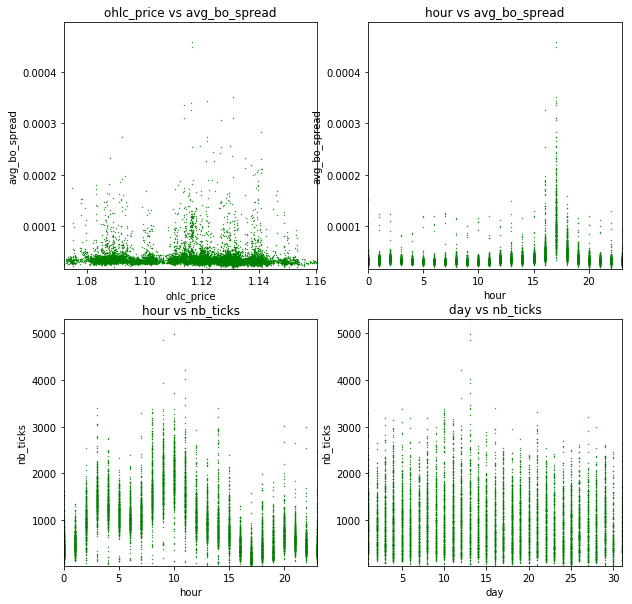

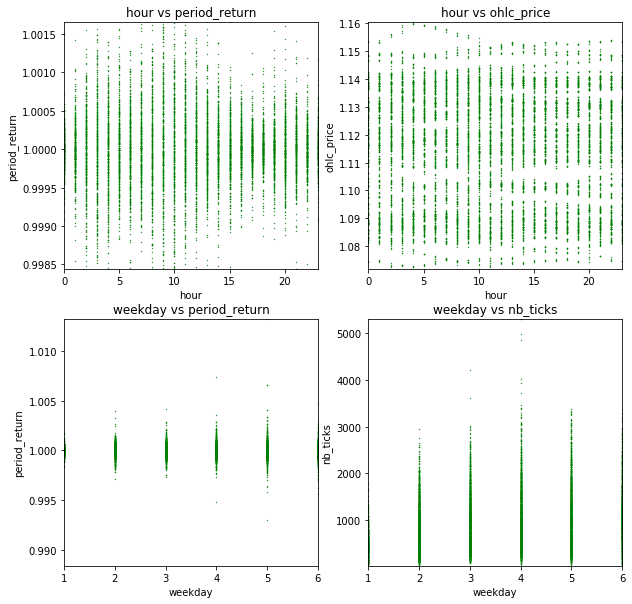

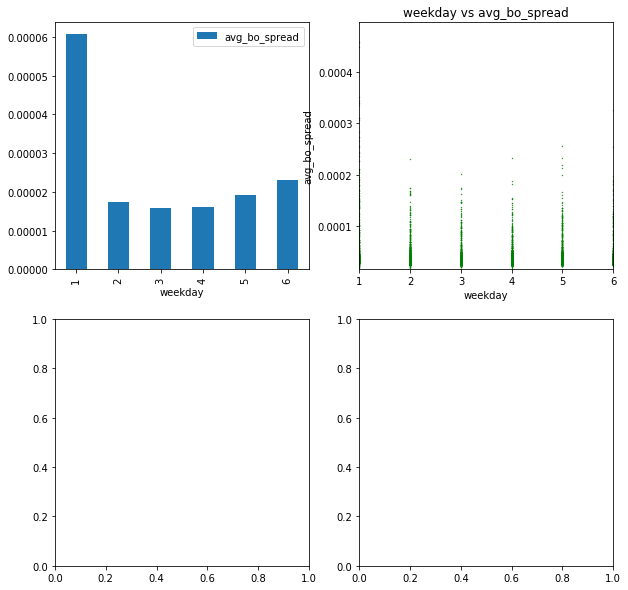

Nb Rows:  10204


In [21]:
# create ohlc prices, analyse distribution, think about feature transformation and de-trending

fig, axarr = plt.subplots(2, 2, figsize=(10,10)) #1 row, 2 cols, x, y
#plt.figure(figsize=(20, 4))
irow, icol = 0,0
#fig.suptitle("frequency distributions")


sns.distplot(df.period_return-1, ax=axarr[irow, icol])
axarr[irow, icol].set_title("dist period_return")
irow,icol=get_next_irow_icol(irow,icol,axarr)

if simname != "bm_kaggle":
    
    sns.distplot(df.avg_bo_spread, ax=axarr[irow, icol])
    axarr[irow, icol].set_title("dist avg_bo_spread")
    irow,icol=get_next_irow_icol(irow,icol,axarr)
    irow,icol = pltGraph("ohlc_price", "avg_bo_spread", irow, icol, df)
    qlow, qhigh = 0.01, 0.99
    df_mask = df.loc[(df.period_return < df.period_return.quantile(qhigh) ) & (df.period_return > df.period_return.quantile(qlow)) & (df.avg_bo_spread < df.avg_bo_spread.quantile(qhigh) ) & (df.avg_bo_spread > df.avg_bo_spread.quantile(qlow)),:]
    #df_mask = df.loc[(df.period_return < df.period_return.quantile(qhigh) ) & (df.period_return > df.period_return.quantile(qlow)) & (df.avg_bo_spread < 0.0001 ) & (df.avg_bo_spread > -0.0001),:]
    irow,icol = pltGraph("period_return", "avg_bo_spread", irow, icol, df_mask)
    
    
    fig,axarr, irow, icol = get_new_plot_and_plot_prev("exp1")
    
    irow,icol = pltGraph("ohlc_price", "avg_bo_spread", irow, icol, df)
    irow,icol = pltGraph("hour", "avg_bo_spread", irow, icol, df)
    irow,icol = pltGraph("hour", "nb_ticks", irow, icol, df)
    irow,icol = pltGraph("day", "nb_ticks", irow, icol, df)
    
    fig,axarr, irow, icol = get_new_plot_and_plot_prev("exp2")
    
    df_mask = df.loc[(df.period_return < df.period_return.quantile(qhigh) ) & (df.period_return > df.period_return.quantile(qlow)),:]
    irow,icol = pltGraph("hour", "period_return", irow, icol, df_mask)
    irow,icol = pltGraph("hour", "ohlc_price", irow, icol, df)
    irow,icol = pltGraph("weekday", "period_return", irow, icol, df)
    irow,icol = pltGraph("weekday", "nb_ticks", irow, icol, df)
    
    fig,axarr, irow, icol = get_new_plot_and_plot_prev("exp3")
    
    res = df.loc[:,["weekday", "avg_bo_spread"]].groupby("weekday").std()
    res.plot(kind="bar", ax=axarr[irow, icol])
    irow,icol=get_next_irow_icol(irow,icol,axarr)
    
    irow,icol = pltGraph("weekday", "avg_bo_spread", irow, icol, df)
    
    #plt.tight_layout()    
    title = "exp4"
    plt.savefig("report graphs/"+title+"_fig.png")
    plt.show()
    

print("Nb Rows: ", df.high_bid.count())

- it seems the hours with the least number of ticks have the highest bo spread. This is expected, as during low activity traders might set spreads wide to avoid surprises.
- period return is between two closing bids, 15 minutes apart. It might be a spurious measure.
- do i have to stick to 15 minute intervals to complete this?
- weekday 1 seems to have higher stdev of avg bo spread

# Add PCA as a feature and show graphs

In [22]:
# Add PCA as a feature instead of for reducing the dimensionality. This improves the accuracy a bit.
from sklearn.decomposition import PCA

df_np = df.copy().values.astype('float32')
pca_features = df.columns.tolist()

pca = PCA(n_components=1)
df['pca'] = pca.fit_transform(df_np)

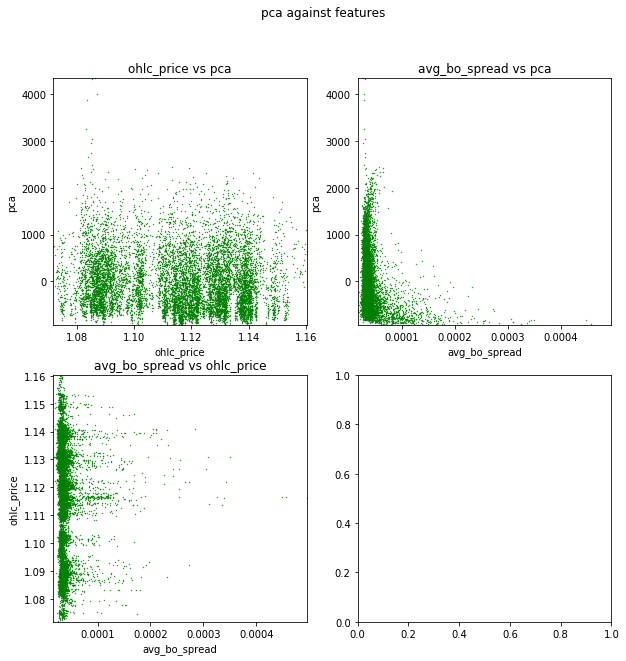

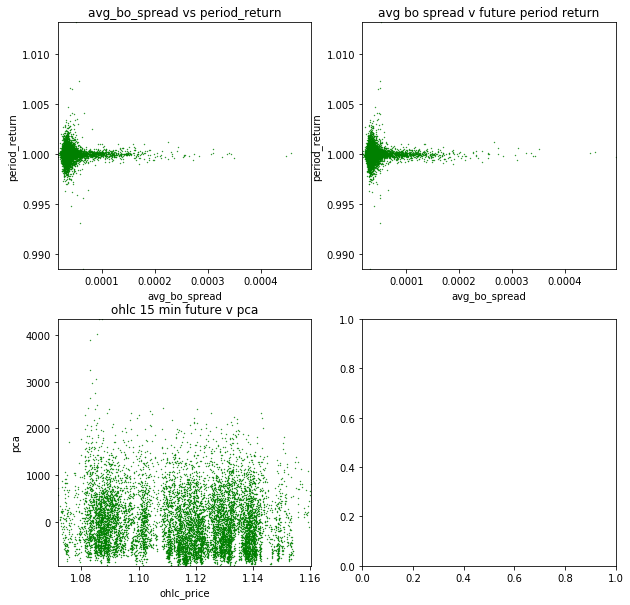

In [23]:

fig, axarr = plt.subplots(2, 2, figsize=(10,10)) #1 row, 2 cols, x, y
irow, icol = 0,0
fig.suptitle("pca against features")

if simname != "bm_kaggle":
    
    irow,icol = pltGraph("ohlc_price", "pca", irow, icol, df)
    irow,icol = pltGraph("avg_bo_spread", "pca", irow, icol, df)
    irow,icol = pltGraph("avg_bo_spread", "ohlc_price", irow, icol, df)
    
    fig,axarr, irow, icol = get_new_plot_and_plot_prev("pca1")
    
    irow,icol = pltGraph("avg_bo_spread", "period_return", irow, icol, df)
    irow,icol = pltGraph("avg_bo_spread", "period_return", irow, icol, df, yval=df['period_return'].shift(periods=1).fillna(method="bfill"), title="avg bo spread v future period return")
    irow,icol = pltGraph("ohlc_price", "pca", irow, icol, df, xval=df['ohlc_price'].shift(periods=1).fillna(method="bfill"), title="ohlc 15 min future v pca")
       
    title = "pca2"
    plt.savefig("report graphs/"+title+"_fig.png")
    plt.show()


# Check feature correlation

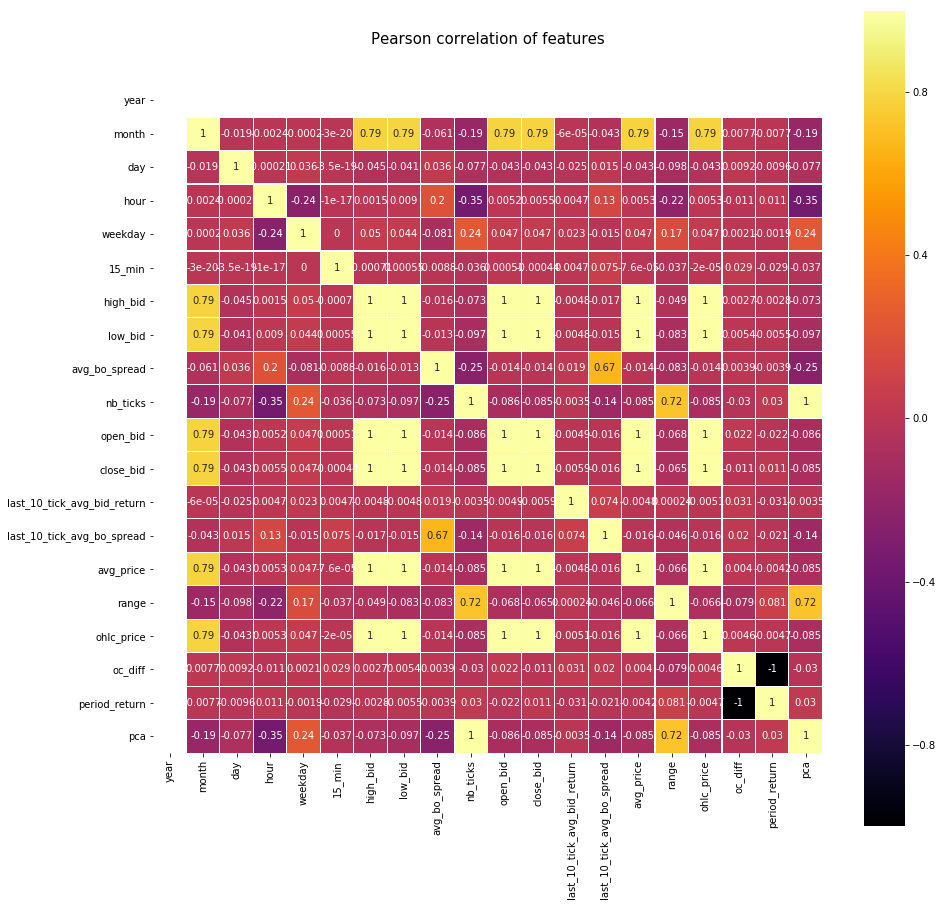

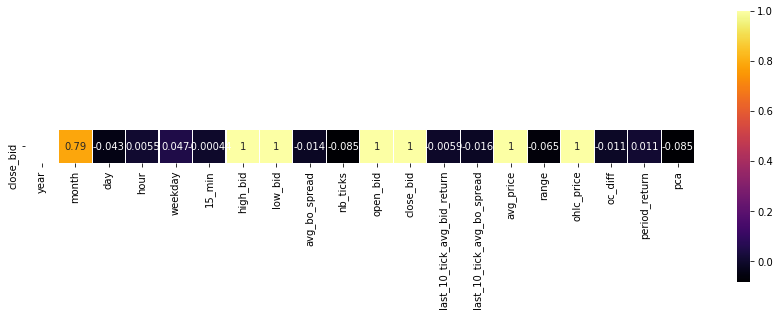

In [24]:
# check feature correlation, to see what correlates with the close price
colormap = plt.cm.inferno
plt.figure(figsize=(15,15))
plt.title('Pearson correlation of features', y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
title = "correl1"
plt.savefig("report graphs/"+title+"_fig.png")
plt.show()

plt.figure(figsize=(15,5))
corr = df.corr()
sns.heatmap(corr[corr.index == 'close_bid'], linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
title = "correl_bid"
plt.savefig("report graphs/"+title+"_fig.png")
plt.show()

# Create dataset function for datascience method

In [25]:
def check_shape(*argv):
    for el in argv:
        print(el.shape)


In [26]:
"""
this creates training examples and actuals for the model
if nb_lookback_rows is above 1, X will have examples each of which is a 20 row dataframe
so the regression model needs to be able to use all those rows to train on
"""

def create_training_set(df, nb_lookback_rows=1):
    
    dataX, dataY = [], [] # for training
    
    # it creates for each row a 20 row lookback dataset
    # this expands the dataset by 20 faculty
    for iRow in range(len(df)-nb_lookback_rows-1): 
        
        df_lookback_rows = df[iRow:(iRow+nb_lookback_rows)] # from example 1 to 21
        dataX.append(df_lookback_rows)
        next_row = df[iRow + nb_lookback_rows] #get example 1+20, so the next point that is to be forecasted
        dataY.append(next_row) 
    
    return np.array(dataX), np.array(dataY) # convert to numpy arrays

# Use Random Forest for feature importance:
Check which feature is most important, based on predicting the next closing price using just one example as training
Do this for each example, and check which features are the best on average
Looking back more than 1 example for each example requires a decision how to use the features. Do recent examples features get more weight?

- scale all features to range 0-1 for faster convergence
- use random forest to find best decision tree to explain closing price

In [27]:
# create random forest regressor - random decision trees, like weak learner, ada boost
from sklearn.ensemble import RandomForestRegressor

# Scale and create datasets
idx_close_bid = df.columns.tolist().index('close_bid') # predict this, should it be return?
df_np = df.values.astype('float32') # so regressor can use it

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_np) # scale features to between 0 and 1 for faster convergence

# Set look_back to 100 which is 100 ticks
# look back is 1 period, to check which features predict best a 1 period return
look_back_rows = 1 # to work with more than one, use alternative reshape
X, y = create_training_set(df_scaled, nb_lookback_rows=look_back_rows) # look back only 1 row
y = y[:,idx_close_bid]
#TODO:X = np.reshape(X, (X.shape[0], X.shape[2]* look_back_rows)) # to get back rows and columns
X = np.reshape(X, (X.shape[0], X.shape[2])) # to get back rows and columns
# extend extra rows into columns, as all the prices during lookback periodd should be used as features.

In [28]:
check_shape(X)

(10202, 20)


In [29]:
# fit model
forest = RandomForestRegressor(n_estimators = 100)
forest = forest.fit(X, y)

In [30]:
# find feature with best explanatory power to predict close price
importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for forest in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1] # get indices for importances
#print(indices)

column_list = df.columns.tolist()
#print(column_list)
print("Feature ranking:")
feature_dict = OrderedDict()
for f in range(X.shape[1]-1):
    #print("%d. %s %d (%f)" % (f, column_list[indices[f]], indices[f], importances[indices[f]]))
    feature_dict[column_list[indices[f]]] = importances[indices[f]]
print(pd.DataFrame([feature_dict]).T)

Feature ranking:
                                    0
close_bid                    0.931158
avg_price                    0.023710
ohlc_price                   0.021060
high_bid                     0.020236
low_bid                      0.002657
open_bid                     0.000565
last_10_tick_avg_bo_spread   0.000092
last_10_tick_avg_bid_return  0.000087
range                        0.000062
avg_bo_spread                0.000060
nb_ticks                     0.000054
pca                          0.000054
period_return                0.000042
oc_diff                      0.000040
hour                         0.000039
day                          0.000037
weekday                      0.000021
15_min                       0.000018
month                        0.000008


# Try linear regression
- sklearn requires numpy arrays as input
- check how close we can get with linear regression
- resources: http://bigdata-madesimple.com/how-to-run-linear-regression-in-python-scikit-learn/
- problem: my features are note independent of each other, eg ohlc price, open bid, close bid etc

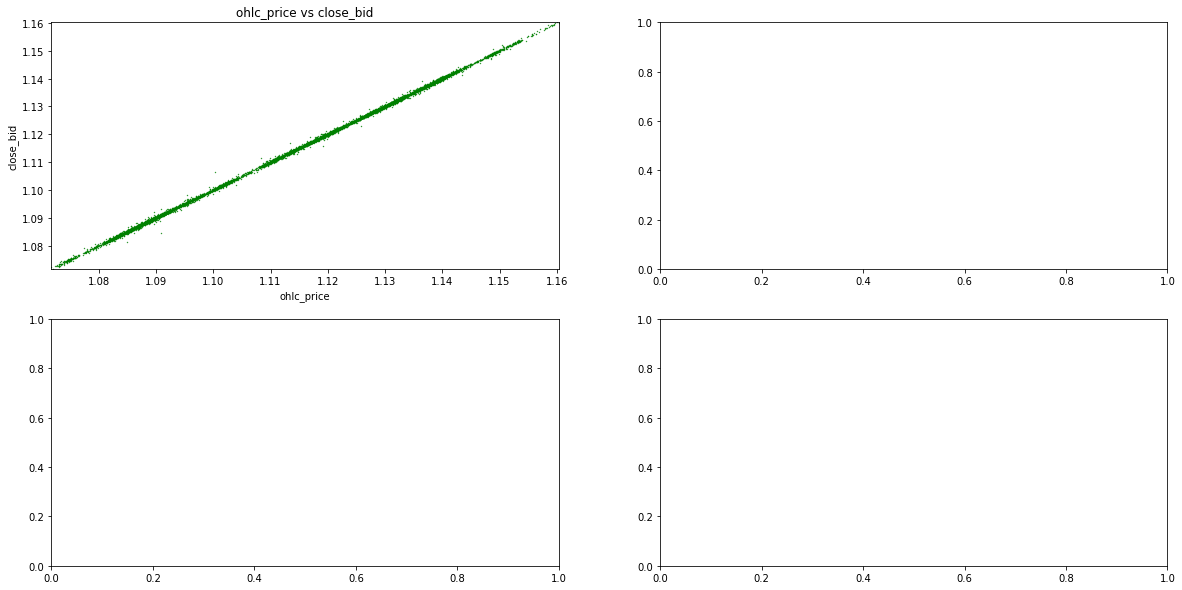

In [31]:
# plot all against close_bid
fig, axarr = plt.subplots(2, 2, figsize=(20,10)) #1 row, 2 cols, x, y
#plt.figure(figsize=(20, 4))
irow, icol = 0,0
icol = pltGraph("ohlc_price", "close_bid", irow, icol, df)
plt.show()


- we may have to address feature correlation as ohlc price seems strongly correlated to close bid, as close bid is contained in it

In [32]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

# df only
X = df.drop("close_bid", axis=1)
y = df.close_bid.shift().values
cols = X.columns


#convert to numpy first
df_np = df.copy().values.astype('float32')
X, y = create_training_set(df_np, 1)
X = np.reshape(X, (X.shape[0], X.shape[2]))
idx_close_bid = df.columns.tolist().index('close_bid') # find index of columns in dataframe
y = y[:,idx_close_bid] # select column to predict
cols = df.columns # i have all here, because close_bid is included as features


# create train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=149, shuffle=False)
check_shape(X, y, X_train, X_test, y_train, y_test)

(10202, 20)
(10202,)
(10053, 20)
(149, 20)
(10053,)
(149,)


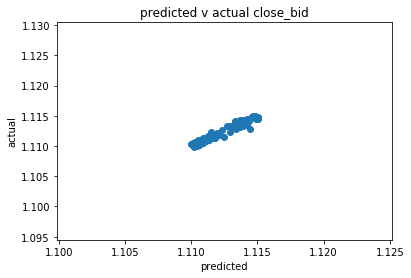

oc_diff                       -0.203693
pca                           -0.028304
low_bid                       -0.009696
last_10_tick_avg_bo_spread    -0.001954
last_10_tick_avg_bid_return   -0.001842
hour                          -0.000109
day                           -0.000031
15_min                        -0.000028
year                           0.000000
month                          0.000007
weekday                        0.000015
avg_price                      0.000347
avg_bo_spread                  0.000480
high_bid                       0.010326
range                          0.019974
nb_ticks                       0.028304
period_return                  0.183617
ohlc_price                     0.199657
open_bid                       0.297073
close_bid                      0.500751
Name: linear regression coefficients, dtype: float64

In [33]:
reg_lasso = linear_model.Lasso(alpha = 0.1) # Lasso takes care of regularisation
reg_linear = linear_model.LinearRegression()

reg_linear.fit(X_train, y_train)
reg_lasso.fit(X_train, y_train)


df_coeff = pd.DataFrame(columns=cols
                     , data=[list(reg_linear.coef_), list(reg_lasso.coef_)]
                     , index=["linear regression coefficients", "lasso regression coefficients"])


# predict all examples and compare to actuals
plt.scatter(reg_linear.predict(X_test), y_test)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("predicted v actual close_bid")
plt.show()

# show regression coefficients
df_coeff = df_coeff.sort_values(by='linear regression coefficients', axis=1)
df_coeff.loc["linear regression coefficients",:]


- what mae is acceptible as a result? If i invest based on my prediction, and it goes the other way i lose money. 
- Therefore, check the directional error, not MAE. Compare close with next close. If my prediction - actual next close has the same sign and value of that measure, count as accurate.

## Check regression errors

In [34]:
def check_error_metrics(df, y_train, y_test, X_train_pred, X_test_pred, y_prev):
    """
        check mse, mae and directional error. This checks regression for directional errors, which would
        probably be done better with classification.
        
        y_prev is the bid price at the end of the current period. It is compared to the predicted bid price
        at the end of the next period.
    
    """

    err_list = []
    
    pred_directions = X_test_pred - y_prev
    act_directions = y_test - y_prev
    pred_returns = X_test_pred / y_prev-1
    act_returns =  y_test / y_prev -1

    

    sign_error = np.sign(pred_directions) != np.sign(act_directions)
    actual_minus_pred = act_directions - pred_directions
    #abs_actual_minus_pred = abs(act_directions) - abs(pred_directions)
    returns_actual_minus_pred = act_returns - pred_returns # larger differences will show correctly, even if signs dont match

    # how often do you make a negative 1 percent return when a positive return was predicted

    err_list= [
        ["mse train", mean_squared_error(y_train, X_train_pred)]
        ,["mse test", mean_squared_error(y_test, X_test_pred)]
        ,["mae train", mean_absolute_error(y_train, X_train_pred)]
        ,["mae test", mean_absolute_error(y_test, X_test_pred)]
        #,["mean avg bo spread", df.avg_bo_spread.mean()] # to see how close we are to a profitable strategy
        

        ,["how often sign of price change is same", (sign_error==False).sum() / len(sign_error)]

    # if correct sign, how often larger than actual value, smaller than actual value
    # is there generally good profit when you got the direction right?
        ,["if same sign, how often are actual returns better than 1 bp absolute in both directions"
          , 100*(abs(act_returns[~sign_error]) > 0.0001).sum() / len(act_returns[~sign_error])]

    # positive surprise
        ,["if same sign, how often are actual returns better than predicted in both directions"
          , 100* (abs(returns_actual_minus_pred[~sign_error]) > 0).sum() / len(returns_actual_minus_pred[~sign_error])]

    

    # not same sign
        ,["if not same sign, how often is actual worse than -1 bp return from predicted in both directions",
         (abs(returns_actual_minus_pred[sign_error]) > 0.0001).sum() / len(returns_actual_minus_pred[sign_error])]
         
        ,["if not same sign, how often is actual worse than -1 bp return absolute in both directions",
         (abs(act_returns[sign_error]) > 0.0001).sum() / len(act_returns[sign_error])]
    ]   
    # show histogram of returns which have a sign error
    fig,axarr = plt.subplots(1,4, figsize=(20,5))
    axarr[0].hist(act_returns[sign_error], bins=40)
    axarr[0].set_title("actual returns where pred and act sign mismatches")
    title = "linreg_sign_error"
    plt.savefig("report graphs/"+title+"_fig.png")
    
    axarr[1].hist(act_returns[~sign_error], bins=40)
    axarr[1].set_title("actual returns where pred and act sign matches")
    title = "linreg_sign_match"
    plt.savefig("report graphs/"+title+"_fig.png")
    
    axarr[2].hist(pred_returns[~sign_error], bins=40)
    axarr[2].set_title("pred returns where sign matches")
    title = "linreg_pred_sign_match"
    plt.savefig("report graphs/"+title+"_fig.png")
    
    axarr[3].hist(pred_returns[sign_error], bins=40)
    axarr[3].set_title("pred returns where sign mismatches")
    title = "linreg_pred_sign_mismatch"
    plt.savefig("report graphs/"+title+"_fig.png")
    
    plt.show()
    
    df_err = pd.DataFrame(err_list)
    
    for el in err_list:
        print(el)
    
    
    return df_err


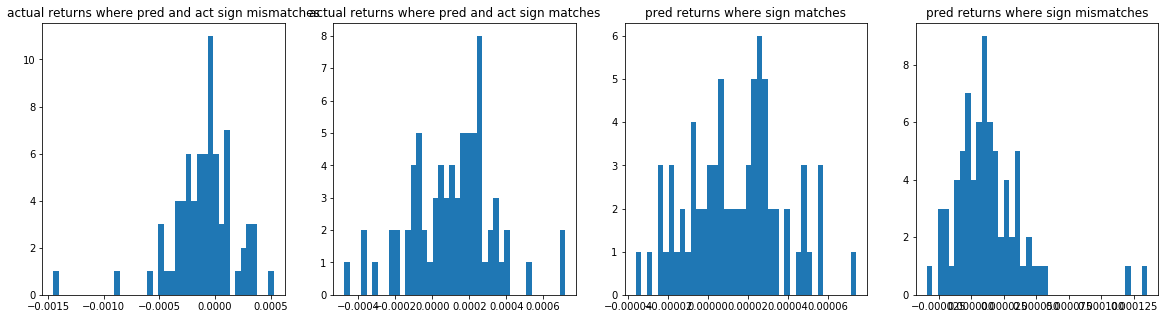

['mse train', 4.4663685e-07]
['mse test', 9.7137992e-08]
['mae train', 0.00042737473]
['mae test', 0.00022883703]
['how often sign of price change is same', 0.49664429530201343]
['if same sign, how often are actual returns better than 1 bp absolute in both directions', 68.918918918918919]
['if same sign, how often are actual returns better than predicted in both directions', 100.0]
['if not same sign, how often is actual worse than -1 bp return from predicted in both directions', 0.69333333333333336]
['if not same sign, how often is actual worse than -1 bp return absolute in both directions', 0.64000000000000001]


In [35]:
df_err = check_error_metrics(df, y_train, y_test
                             , reg_linear.predict(X_train), reg_linear.predict(X_test)
                             , X_test[:,idx_close_bid])

## Show log

In [36]:
# log results
log=False

if log:
    
    simname_lin= simname + " linear regression"
    sim_lin_desc = sim_desc + " 1 row lookback"
    
    dict_err= OrderedDict(zip(df_err[0], df_err[1]))
    
    list_stats=OrderedDict()
    
    list_stats["simname"] = simname_lin
    list_stats["sim_desc"] = sim_lin_desc
    list_stats["MSE"] = dict_err["mse test"]
    list_stats["MAE"] = dict_err["mae test"]
    
    differences_described = pd.Series(reg_linear.predict(X_test) - y_test).describe()

    list_stats.update(OrderedDict(differences_described))
    list_stats.update(dict_err)
    
    results = pd.DataFrame([list_stats])
    #results.to_excel("log_results.xlsx")
    if os.path.isfile("log_results.xlsx"):
        log_results = pd.read_excel("log_results.xlsx")
        log_results.loc[len(log_results),:] = list_stats.values()
        log_results.to_excel("log_results.xlsx")
    #log_results

In [37]:
dfplot = pd.read_excel("log_results.xlsx").T
dfplot

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
simname,kaggle linear regression,bm_kaggle,kaggle param my dataset linear regression,kaggle param my dataset,kaggle param my dataset linear regression,kaggle param my dataset,bm_with_lookback_10,bm_with_lookback_2,bm_with_lookback_30,bm_with_lookback_60,bm_with_lookback_5,bm_with_lookback_5_batch_100,bm_with_lookback_5_batch_1000,bm_with_lookback_5_epochs_500,bm_with_lookback_5_epochs_1000,bm_with_lookback_5_epochs_500,bm_with_lookback_5_epochs_500,bm_with_lookback_5_epochs_500,bm_with_lookback_5_epochs_500,bm_with_lookback_5_epochs_500
sim_desc,kaggle 1 row lookback,kaggle bm has 200 epoch and batch size 500 and...,\n kaggle params with my dataset\n 1 ro...,kaggle bm has 200 epoch and batch size 500 and...,\n kaggle params with my dataset\n 1 ro...,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n
MSE,7.78252e-06,1.20446e-07,6.54157e-08,2.45924e-07,9.72119e-08,5.59631e-07,2.63716e-07,5.11102e-07,3.56223e-07,3.40443e-07,1.9192e-07,2.50884e-07,4.70728e-07,1.3067e-07,3.05962e-07,3.4891e-07,1.31174e-07,2.15744e-07,0.00170677,4.07329e-07
MAE,0.00233305,0.000278994,0.000202497,0.000429252,0.000228927,0.000571841,0.000391006,0.000586614,0.000425628,0.000417161,0.000348615,0.000401295,0.000571145,0.000272417,0.000450971,0.000467292,0.00027801,0.000354073,0.0412842,0.000492958
count,149,149,103,102,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149,149
mean,0.00230515,9.99558e-05,-2.86507e-05,0.000327489,9.69676e-06,-0.000226223,0.000291342,0.0004673,0.000211435,4.8595e-05,-0.000185057,0.000349894,-0.000443419,-8.11183e-06,0.000421663,0.000381116,-4.8155e-05,0.000262991,-0.0412842,-0.000218943
std,0.00157654,0.000333468,0.000255398,0.00037423,0.000312688,0.000715464,0.000424316,0.000542872,0.00056002,0.000583409,0.000398422,0.000359619,0.000525319,0.000362611,0.000359204,0.00045281,0.000360175,0.000384149,0.00154687,0.000601516
min,-0.00105977,-0.00100839,-0.000780582,-0.000641942,-0.000779629,-0.0018394,-0.000664353,-0.00124609,-0.00115061,-0.00137413,-0.00126648,-0.000430465,-0.00178719,-0.000883698,-0.000402927,-0.00069344,-0.00086534,-0.000657678,-0.04354,-0.00172734
25%,0.000746131,-0.00011158,-0.000195682,0.000149757,-0.000189185,-0.000689983,2.43187e-05,0.000217319,-0.0001086,-0.000298381,-0.000445724,0.000124812,-0.000771403,-0.000214458,0.00016892,0.000154614,-0.000270247,6.19888e-06,-0.0424299,-0.000597596
50%,0.00332856,0.000176191,-2.80142e-05,0.000362039,-7.27177e-06,-0.000272751,0.0002352,0.000464559,0.000171542,-4.79221e-05,-0.000210404,0.000325561,-0.000485659,-4.82798e-05,0.000408173,0.000347495,-8.53539e-05,0.000258803,-0.04193,-0.000188231


In [38]:
df_to_image(dfplot, "report graphs/", "simlog")

0

## Plot residuals

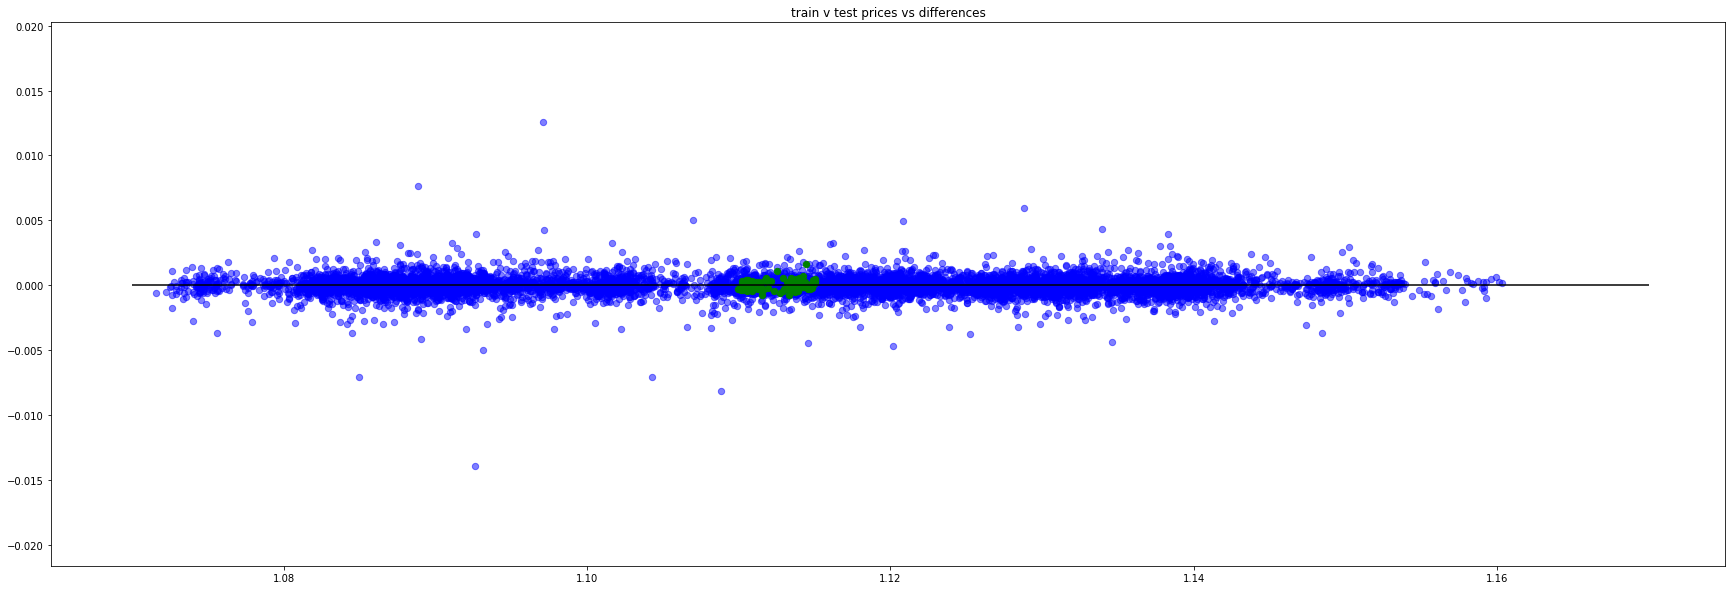

In [39]:
plt.figure(figsize=(30,10))
plt.scatter(reg_linear.predict(X_train), reg_linear.predict(X_train) - y_train, c='b', s=40, alpha=0.5)
plt.scatter(reg_linear.predict(X_test), reg_linear.predict(X_test) - y_test, c='g', s=40)
plt.hlines(y=0, xmin=1.07, xmax = 1.17)
plt.title("train v test prices vs differences")
plt.show()

In [40]:
print("pred: %f, actual: %f" % (reg_linear.predict(X_test[0,:].reshape(1,-1)), y_test[0]))

pred: 1.114218, actual: 1.113520


## Try ridge regression, to be more robust to correlation in features

C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.239686741096648e-09
  ' condition number: {}'.format(rcond), RuntimeWarning)


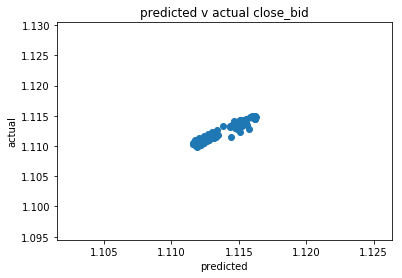

mse train all feature:  9.63547e-07
mse test all feature:  2.02412e-06


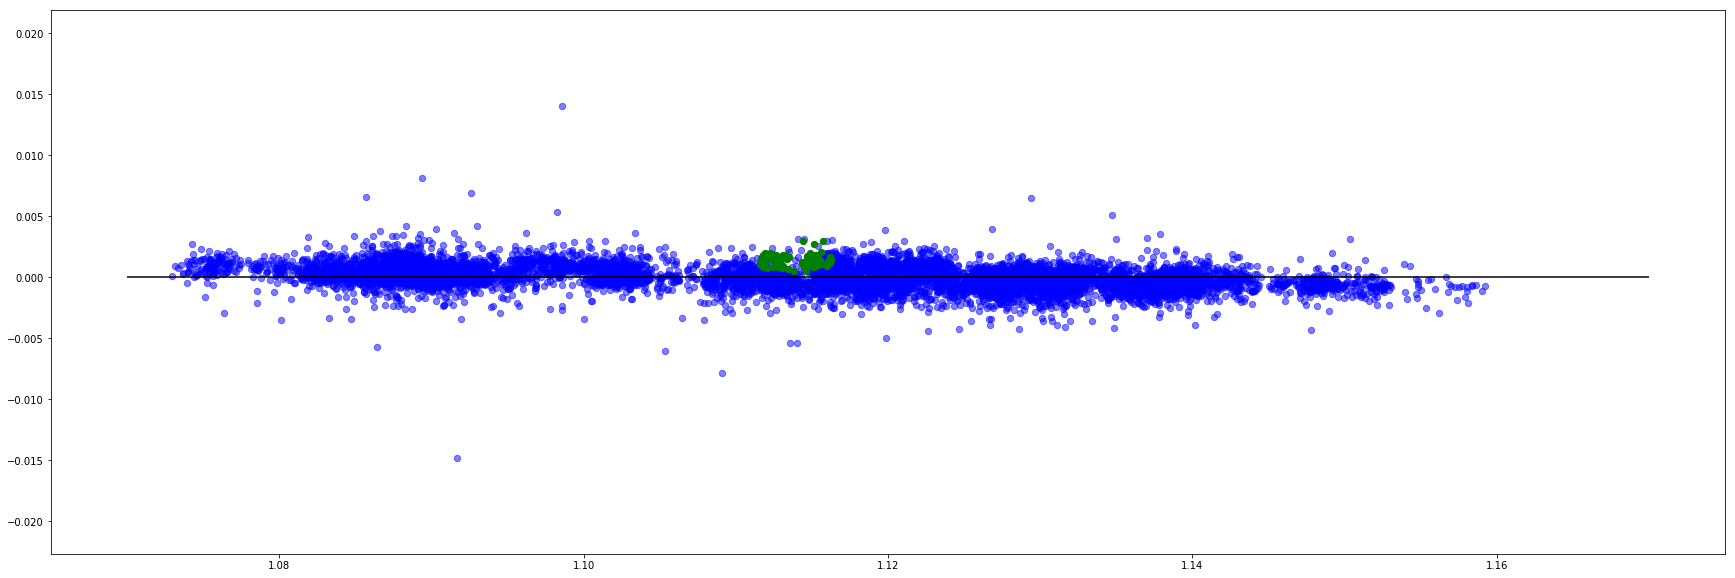

In [41]:
reg = linear_model.Ridge (alpha = .5)
reg.fit(X_train, y_train) 
reg.coef_


df_coeff = pd.DataFrame(columns=cols
                     , data=[list(reg.coef_)]
                     , index=["ridge regression coefficients"])



# predict all examples and compare to actuals
plt.scatter(reg.predict(X_test), y_test)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("predicted v actual close_bid")
plt.show()


df_coeff.sort_values(by='ridge regression coefficients', axis=1)

print("mse train all feature: ", np.mean((reg.predict(X_train) - y_train) ** 2))
print("mse test all feature: ", np.mean((reg.predict(X_test) - y_test) ** 2))

plt.figure(figsize=(30,10))
plt.scatter(reg.predict(X_train), reg.predict(X_train) - y_train, c='b', s=40, alpha=0.5)
plt.scatter(reg.predict(X_test), reg.predict(X_test) - y_test, c='g', s=40)
plt.hlines(y=0, xmin=1.07, xmax = 1.17)
plt.show()

# Run LSTM Model to predict close bid in next 15 min
- scale features to range 0-1 to speed up convergence
- set a larger lookback windows, so LSTM has something to work with and can take a decision which part of history to prioritise
- todo: make it do error on the sign- for that need to get the sign between next and X[bid]
- 1% test size, 10% of 99% validation size
- try to also predict direction. y_pred - X_test close versus y_act - X_test close

## Predict sign only

In [42]:
if runLSTMBinary:
    # Scale and create datasets
    idx_close_bid = df.columns.tolist().index('close_bid')
    df_np = df.values.astype('float32')

    # Scale the examples
    df_scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = df_scaler.fit_transform(df_np)

    # Scale the actuals columns, but not the real values
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    t_y = df['close_bid'].values.astype('float32')
    t_y = np.reshape(t_y, (-1, 1))
    y_scaler = y_scaler.fit(t_y) # create a fitted y scaler

    # Set look_back to 20 which is 5 hours (15min*20)
    X, y_orig = create_training_set(df_scaled, nb_lookback_rows=40)
    #y_return_sign = np.sign(y[:,idx_close_bid] - X[:,0,idx_close_bid]) # these are the actuals
    y_return_sign = y_orig[:,idx_close_bid] - X[:,0,idx_close_bid] # these are the actuals
    y = np.sign(y_return_sign) # an array of -1, 1 and 0

    y = pd.get_dummies(y).values.astype('float32')



    # need to create a binarised vector, one positive class, one negative class
    #y_pred_return_sign = # comes from model

## Predict exact price value

In [108]:
simname = "bm_with_lookback_5_epochs_500"
import numpy as np
np.random.seed(2017)


if not runLSTMBinary:
    # Scale and create datasets
    idx_close_bid = df.columns.tolist().index('close_bid')
    #idx_high = df.columns.tolist().index('high_bid')
    #idx_low = df.columns.tolist().index('low_bid')
    df_np = df.values.astype('float32')

    # Scale the examples
    df_scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = df_scaler.fit_transform(df_np)

    # Scale the actuals columns, but not the real values
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    t_y = df['close_bid'].values.astype('float32')
    t_y = np.reshape(t_y, (-1, 1))
    y_scaler = y_scaler.fit(t_y) # create a fitted y scaler

    # Set look_back to 20 which is 5 hours (15min*20)
    X, y = create_training_set(df_scaled, nb_lookback_rows=5) # bm kaggle is 20
    y = y[:,idx_close_bid]

In [109]:
# Set training data size
# We have a large enough dataset. So divid into 99% training and val (10% of those 99%) / 1% test set
import sklearn
sklearn.__version__
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =149, shuffle=False)       # hardcode to make percentages correct
check_shape(X, y, X_train, X_test, y_train, y_test)

(10198, 5, 20)
(10198,)
(10049, 5, 20)
(149, 5, 20)
(10049,)
(149,)


In [110]:
if useKaggle:
    train_size = int(len(X) * 0.99)
    trainX = X[:train_size]
    trainY = y[:train_size]
    testX = X[train_size:]
    testY = y[train_size:]
    check_shape(X, y, X_train, X_test, y_train, y_test)

## Run LSTM Model

In [111]:
from keras.backend import categorical_crossentropy
# ensure there is a 1st derivative! else get none error
# it will check in which direction this error goesn down and walk there
# maybe it has issue because sign is not continuous...
# just use categorical crossentropy, it does exactly what i need much better
def ret_direction_error(y_true, y_pred):
    
    # this guy puts everything into numpy before working on it https://stackoverflow.com/questions/46411573/keras-custom-loss-function-not-working
     
    out = categorical_crossentropy(y_true, y_pred)
    
    return out
    
    # y_true is y_train, y_pred is what the model gives me
    # so should set y_true to the return sign? and stop training on absolute value, but make sure sign is right

In [112]:
"""

kaggle:
model = Sequential()
model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True)) # does not take into account nb examples
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
#model.add(LSTM(10, return_sequences=True)) # a second layer of 10 really helps get the loss to 7 by 10th epoch
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='relu')) 

"""

"\n\nkaggle:\nmodel = Sequential()\nmodel.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True)) # does not take into account nb examples\nmodel.add(LSTM(20, return_sequences=True))\nmodel.add(LSTM(10, return_sequences=True))\n#model.add(LSTM(10, return_sequences=True)) # a second layer of 10 really helps get the loss to 7 by 10th epoch\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(4, return_sequences=False))\nmodel.add(Dense(4, kernel_initializer='uniform', activation='relu'))\nmodel.add(Dense(1, kernel_initializer='uniform', activation='relu')) \n\n"

In [113]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense
import keras.backend as K
import tensorflow as tf

# create a small LSTM network
# shoudl first input number match nb of lookback rows?
model = Sequential()
model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True)) # does not take into account nb examples
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
#model.add(LSTM(10, return_sequences=True)) # a second layer of 10 really helps get the loss to 7 by 10th epoch
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='uniform', activation='relu'))



# for price prediction
if not runLSTMBinary:
    model.add(Dense(1, kernel_initializer='uniform', activation='relu')) # this compresses everything to one output in the final layer
    #model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae', 'mse', 'accuracy'])
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse', 'accuracy'])
    
    
# for direction prediction
if runLSTMBinary:
    # need a softmax output for category predictions
    model.add(Dense(3, activation="softmax"))   

    # loss: optimises this - https://keras.io/losses/
    # loss will show up in the history under 'loss'
    model.compile(loss=ret_direction_error, optimizer='adam', metrics=['mae', 'mse', ret_direction_error, 'accuracy'])
    
#print(model.summary())
# def myprint(s):
#     simname = "kagag"
#     with open('model weights/'+simname+'model_summary.txt','w+') as f:
#         print(s, file=f)

# model.summary(print_fn=myprint)
model_json = model.to_json()
with open("model weights/"+simname+"_model.json", "w") as json_file:
    json_file.write(model_json)
print(model.summary())
with open('model weights/'+simname+'_model_summary.txt','w+') as f:
         f.write(model.to_yaml())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 5, 20)             3280      
_________________________________________________________________
lstm_10 (LSTM)               (None, 5, 20)             3280      
_________________________________________________________________
lstm_11 (LSTM)               (None, 5, 10)             1240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 4)                 240       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total para

In [114]:
#simname = "500_epochs_40_lookback_pca_unshuffled_binary"
#sim_desc = "kaggle bm has 200 epoch and batch size 500 and no period return as a feature"
#simname = "bm_kaggle"
#simname = "kaggle param my dataset"


In [115]:
# make results reproducible: https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [116]:

# Save the best weight during training. Cant handel custom functions for errors
from keras.callbacks import ModelCheckpoint
epoch = 500

# write custom errors as string, they seem to refer to the key in err.history dict
if not runLSTMBinary:
    #checkpoint = ModelCheckpoint(simname + ".weights.best.hdf5", monitor='val_mean_absolute_error', verbose=1, save_best_only=True, mode='min')
    checkpoint = ModelCheckpoint("model weights/"+simname + ".weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

if runLSTMBinary:
    checkpoint = ModelCheckpoint("model weights/"+simname + ".weights.best.hdf5", monitor='val_ret_direction_error', verbose=1, save_best_only=True, mode='min')

# Fit
"""
it seems batch size controls convergence speed a lot! Batch size tells how many examples are propagated through the network.
Weights are adjusted based on results with these examples. This is useful if the full dataset takes too much memory
It also speeds up training, as you will converge quicker (dont have to wait for a full iteration of each example to adjust weights).

With more features to train on, convergence seems slower. To get to the same level, i take more epochs.
"""
callbacks_list = [checkpoint]
%time err = model.fit(X_train, y_train, epochs=epoch, batch_size=500, verbose=0, callbacks=callbacks_list, validation_split=0.1, shuffle=False)

Epoch 00001: val_mean_squared_error improved from inf to 0.32356, saving model to model weights/bm_with_lookback_5_epochs_500.weights.best.hdf5
Epoch 00002: val_mean_squared_error improved from 0.32356 to 0.29462, saving model to model weights/bm_with_lookback_5_epochs_500.weights.best.hdf5
Epoch 00003: val_mean_squared_error improved from 0.29462 to 0.25314, saving model to model weights/bm_with_lookback_5_epochs_500.weights.best.hdf5
Epoch 00004: val_mean_squared_error improved from 0.25314 to 0.19960, saving model to model weights/bm_with_lookback_5_epochs_500.weights.best.hdf5
Epoch 00005: val_mean_squared_error improved from 0.19960 to 0.14092, saving model to model weights/bm_with_lookback_5_epochs_500.weights.best.hdf5
Epoch 00006: val_mean_squared_error improved from 0.14092 to 0.08855, saving model to model weights/bm_with_lookback_5_epochs_500.weights.best.hdf5
Epoch 00007: val_mean_squared_error improved from 0.08855 to 0.05168, saving model to model weights/bm_with_lookback

Epoch 00109: val_mean_squared_error did not improve
Epoch 00110: val_mean_squared_error did not improve
Epoch 00111: val_mean_squared_error did not improve
Epoch 00112: val_mean_squared_error did not improve
Epoch 00113: val_mean_squared_error did not improve
Epoch 00114: val_mean_squared_error did not improve
Epoch 00115: val_mean_squared_error did not improve
Epoch 00116: val_mean_squared_error did not improve
Epoch 00117: val_mean_squared_error did not improve
Epoch 00118: val_mean_squared_error did not improve
Epoch 00119: val_mean_squared_error did not improve
Epoch 00120: val_mean_squared_error did not improve
Epoch 00121: val_mean_squared_error did not improve
Epoch 00122: val_mean_squared_error did not improve
Epoch 00123: val_mean_squared_error did not improve
Epoch 00124: val_mean_squared_error did not improve
Epoch 00125: val_mean_squared_error did not improve
Epoch 00126: val_mean_squared_error did not improve
Epoch 00127: val_mean_squared_error did not improve
Epoch 00128:

Epoch 00267: val_mean_squared_error did not improve
Epoch 00268: val_mean_squared_error did not improve
Epoch 00269: val_mean_squared_error did not improve
Epoch 00270: val_mean_squared_error did not improve
Epoch 00271: val_mean_squared_error did not improve
Epoch 00272: val_mean_squared_error did not improve
Epoch 00273: val_mean_squared_error did not improve
Epoch 00274: val_mean_squared_error did not improve
Epoch 00275: val_mean_squared_error did not improve
Epoch 00276: val_mean_squared_error did not improve
Epoch 00277: val_mean_squared_error did not improve
Epoch 00278: val_mean_squared_error did not improve
Epoch 00279: val_mean_squared_error did not improve
Epoch 00280: val_mean_squared_error did not improve
Epoch 00281: val_mean_squared_error did not improve
Epoch 00282: val_mean_squared_error did not improve
Epoch 00283: val_mean_squared_error did not improve
Epoch 00284: val_mean_squared_error did not improve
Epoch 00285: val_mean_squared_error did not improve
Epoch 00286:

Epoch 00425: val_mean_squared_error did not improve
Epoch 00426: val_mean_squared_error did not improve
Epoch 00427: val_mean_squared_error did not improve
Epoch 00428: val_mean_squared_error did not improve
Epoch 00429: val_mean_squared_error did not improve
Epoch 00430: val_mean_squared_error did not improve
Epoch 00431: val_mean_squared_error did not improve
Epoch 00432: val_mean_squared_error did not improve
Epoch 00433: val_mean_squared_error did not improve
Epoch 00434: val_mean_squared_error did not improve
Epoch 00435: val_mean_squared_error did not improve
Epoch 00436: val_mean_squared_error did not improve
Epoch 00437: val_mean_squared_error did not improve
Epoch 00438: val_mean_squared_error did not improve
Epoch 00439: val_mean_squared_error did not improve
Epoch 00440: val_mean_squared_error did not improve
Epoch 00441: val_mean_squared_error improved from 0.00009 to 0.00009, saving model to model weights/bm_with_lookback_5_epochs_500.weights.best.hdf5
Epoch 00442: val_mea

In [117]:
dill.dump(err.history, open("model weights/"+simname+"_first_err.dat", 'wb'))

## Check testing errors
- it converges to a low number very fast - how can i get more detail
- but if i split using cross val split with random state, it takes ages to converge. Maybe i should only allow training on the past, as the model will always be used to predict the future. So training on random parts of the timeseries to predict other random parts might destroy historical trends that influence the future, and can be learned by the model.
- train it on directional error for more useful results. Need y_train - X_train[:,idx_close_bid] as feature and evaluate against y_true - X_train[:,idx_close_bid]
- it seems the model always predicts negative, so column zero
- its easier to optimise over mse than mae, because values bigger and would decline more, so better gradients.

Issues:
- cannot checkpoint custom error functions
- cannot write custom error functions
- cannot debug custom error functions

In [118]:
err_history = dill.load(open("model weights/"+simname+"_first_err.dat", 'rb'))

In [119]:

#pd.DataFrame(model.predict(X_train))
if runLSTMBinary:
    print(pd.DataFrame(y_train).sum()) # classes are quite balanced
    pd.DataFrame(err_history)

In [120]:
print("smallest validation MAE: ", min(err_history['val_mean_absolute_error']))
print("smallest validation MSE: ", min(err_history['val_mean_squared_error']))



smallest validation MAE:  0.00658093237629
smallest validation MSE:  8.5761917175e-05


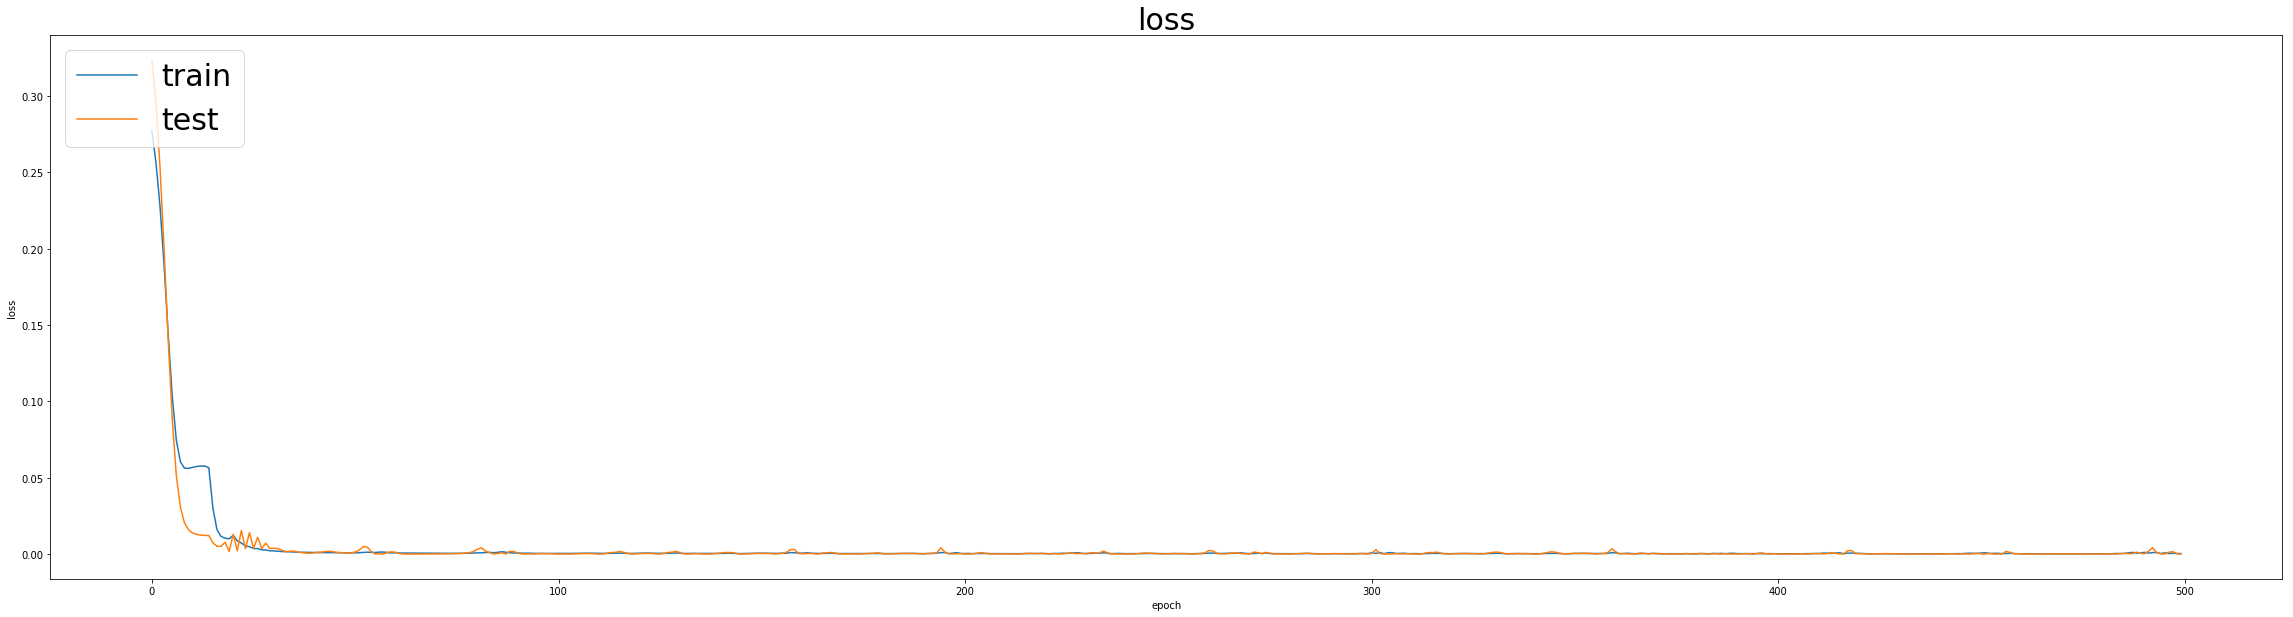

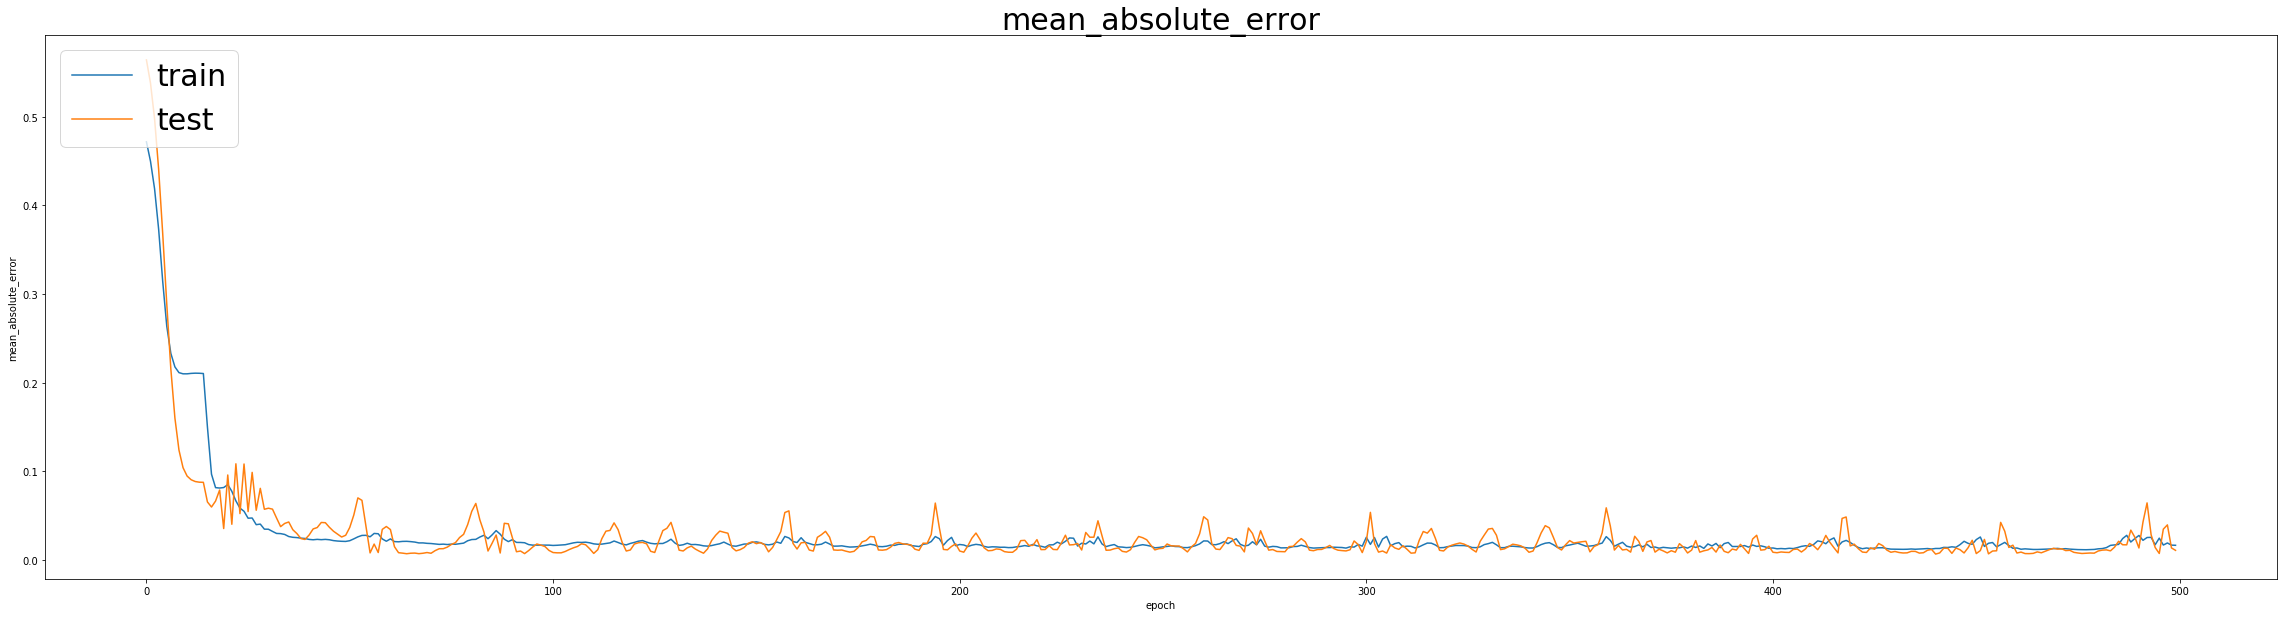

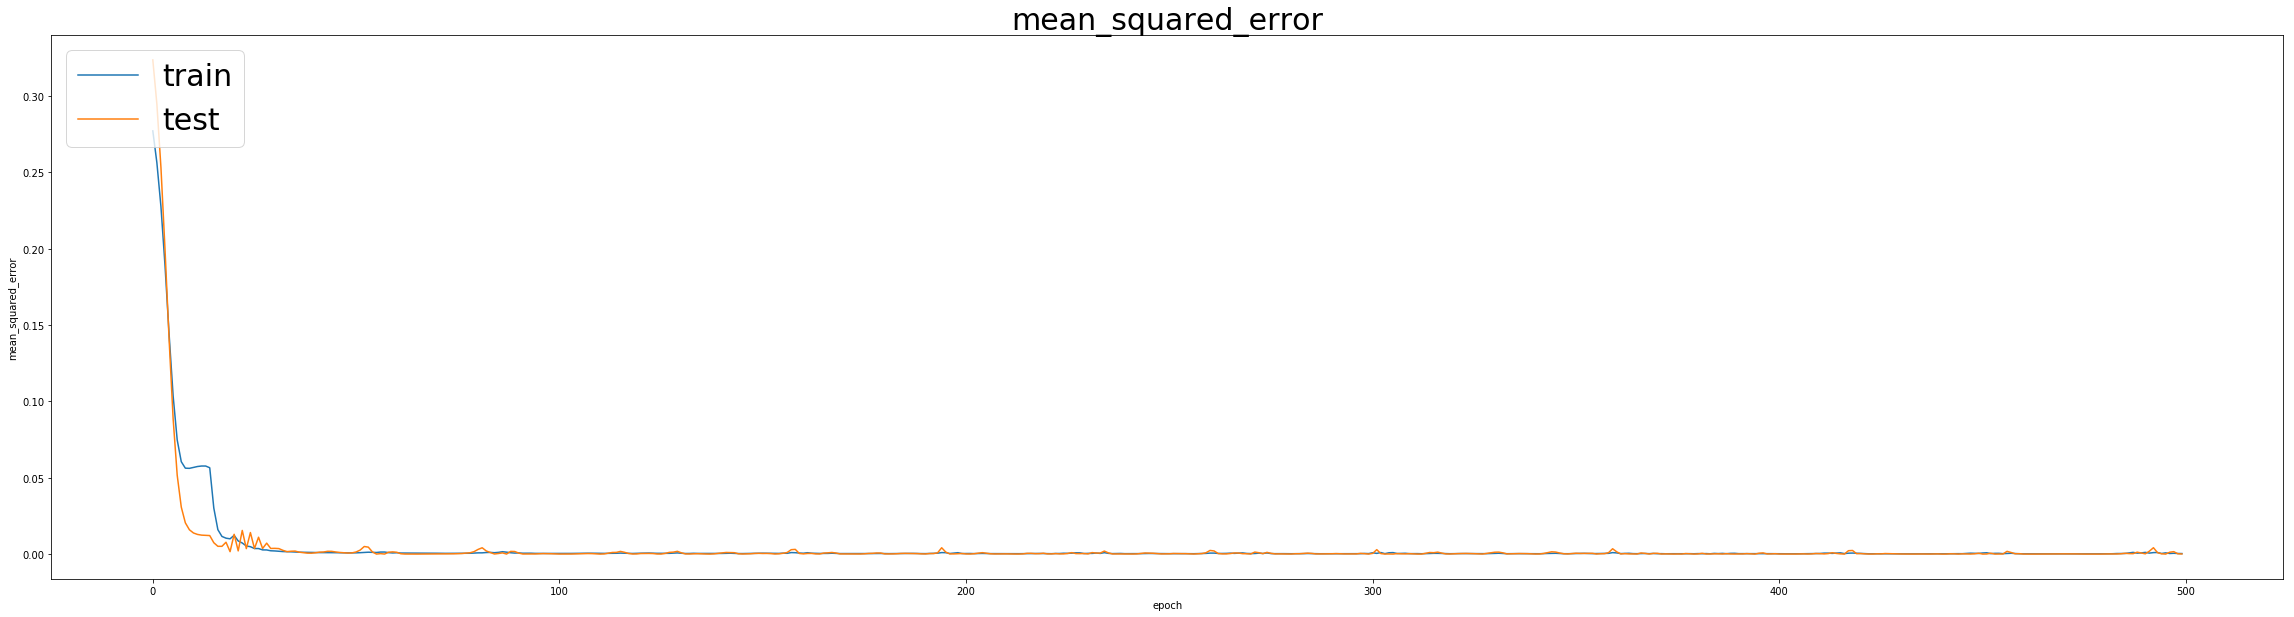

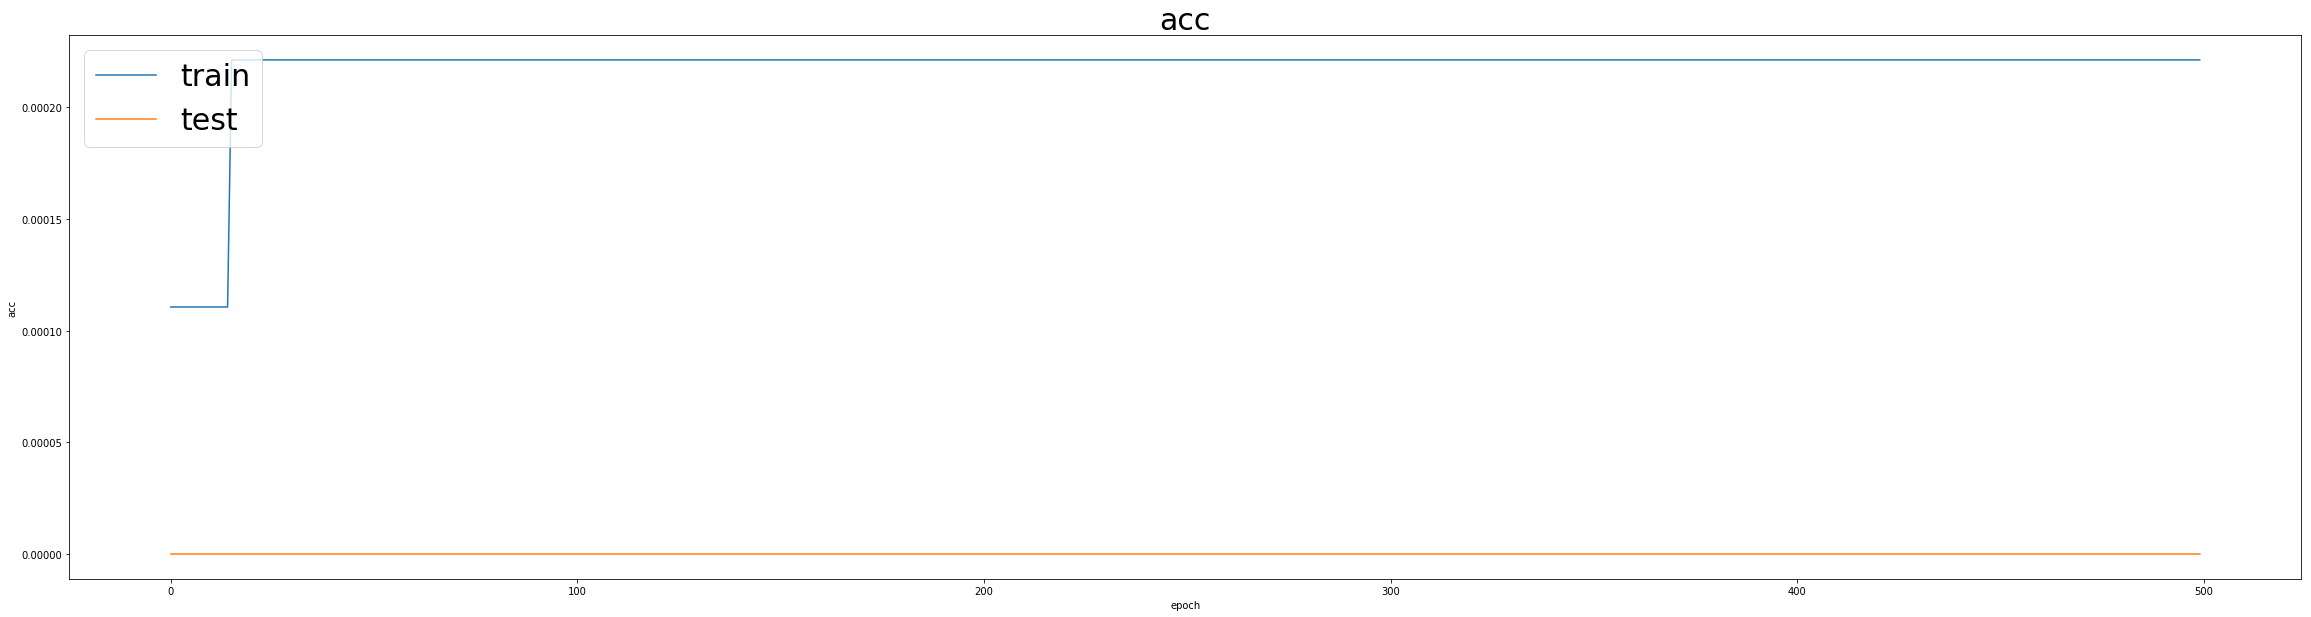

In [121]:
for error_metric in list(err_history.keys()):
    if 'val' not in error_metric:
        plt.figure(figsize=(40,10))
        plt.plot(err_history[error_metric])
        plt.plot(err_history['val_' + error_metric])
        plt.title(error_metric, fontsize=30)
        plt.ylabel(error_metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left', fontsize=30)
        plt.show()

## Rerun LSTM with decaying learning rate:

As seen from the above, the model seems to have converged nicely, but the mean absolute error on the development data remains at ~0.003X which means the model is unusable in practice. Ideally, we want to get ~0.0005. Let's go back to the best weight, and decay the learning rate while retraining the model

We need this to get inside the average bid offer spread for EUR/USD, so 1.10115 - 1.10110. But lets not forget the data is scaled. Maybe it looks better when we unscale it.

In [122]:
# tune model by starting from best weights and rerunning with decaying learning rate
# Load the weight that worked the best
model.load_weights("model weights/"+simname+".weights.best.hdf5")
# create a new checkpoint to save improved weights under different name

checkpoint = ModelCheckpoint("model weights/"+simname + ".better_weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')
#epoch=60

# Train again with decaying learning rate
from keras.callbacks import LearningRateScheduler
import keras.backend as K

def scheduler(epoch):
    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
lr_decay = LearningRateScheduler(scheduler) # do sth to learning rate

callbacks_list = [checkpoint, lr_decay] # checkin with these once in a while
err_decay_lr = model.fit(X_train, y_train, epochs=int(epoch/3), batch_size=500, verbose=0, callbacks=callbacks_list, validation_split=0.1)

Epoch 00001: val_mean_squared_error improved from inf to 0.00012, saving model to model weights/bm_with_lookback_5_epochs_500.better_weights.best.hdf5
Epoch 00002: val_mean_squared_error improved from 0.00012 to 0.00011, saving model to model weights/bm_with_lookback_5_epochs_500.better_weights.best.hdf5
lr changed to 0.0009000000427477062
Epoch 00003: val_mean_squared_error improved from 0.00011 to 0.00011, saving model to model weights/bm_with_lookback_5_epochs_500.better_weights.best.hdf5
Epoch 00004: val_mean_squared_error did not improve
lr changed to 0.0008100000384729356
Epoch 00005: val_mean_squared_error did not improve
Epoch 00006: val_mean_squared_error did not improve
lr changed to 0.0007290000503417104
Epoch 00007: val_mean_squared_error did not improve
Epoch 00008: val_mean_squared_error did not improve
lr changed to 0.0006561000715009868
Epoch 00009: val_mean_squared_error did not improve
Epoch 00010: val_mean_squared_error did not improve
lr changed to 0.000590490043396

Epoch 00108: val_mean_squared_error did not improve
lr changed to 3.381392343726475e-06
Epoch 00109: val_mean_squared_error did not improve
Epoch 00110: val_mean_squared_error did not improve
lr changed to 3.043253150281089e-06
Epoch 00111: val_mean_squared_error did not improve
Epoch 00112: val_mean_squared_error did not improve
lr changed to 2.7389278557166107e-06
Epoch 00113: val_mean_squared_error did not improve
Epoch 00114: val_mean_squared_error did not improve
lr changed to 2.465035049681319e-06
Epoch 00115: val_mean_squared_error did not improve
Epoch 00116: val_mean_squared_error did not improve
lr changed to 2.2185315856404485e-06
Epoch 00117: val_mean_squared_error did not improve
Epoch 00118: val_mean_squared_error did not improve
lr changed to 1.996678406612773e-06
Epoch 00119: val_mean_squared_error did not improve
Epoch 00120: val_mean_squared_error did not improve
lr changed to 1.7970104636333418e-06
Epoch 00121: val_mean_squared_error did not improve
Epoch 00122: val_

In [123]:
dill.dump(err_decay_lr.history, open("model weights/"+simname+"lr_decay_history.dat", 'wb'))

In [124]:
simname = "bm_with_lookback_5_epochs_500"

In [125]:
err_lr_decay_history = dill.load(open("model weights/"+simname+"lr_decay_history.dat", 'rb'))

## Check testing errors after decaying learning rate
 - here error chart resolution is better, as we start from the trained model

In [126]:
print("smallest validation MAE: ", min(err_history['val_mean_absolute_error']))
print("smallest validation MSE: ", min(err_history['val_mean_squared_error']))
print("decay lr: smallest validation MAE: ", min(err_lr_decay_history['val_mean_absolute_error']))
print("decay lr: smallest validation MSE: ", min(err_lr_decay_history['val_mean_squared_error']))


smallest validation MAE:  0.00658093237629
smallest validation MSE:  8.5761917175e-05
decay lr: smallest validation MAE:  0.00769220754523
decay lr: smallest validation MSE:  0.000106495437214


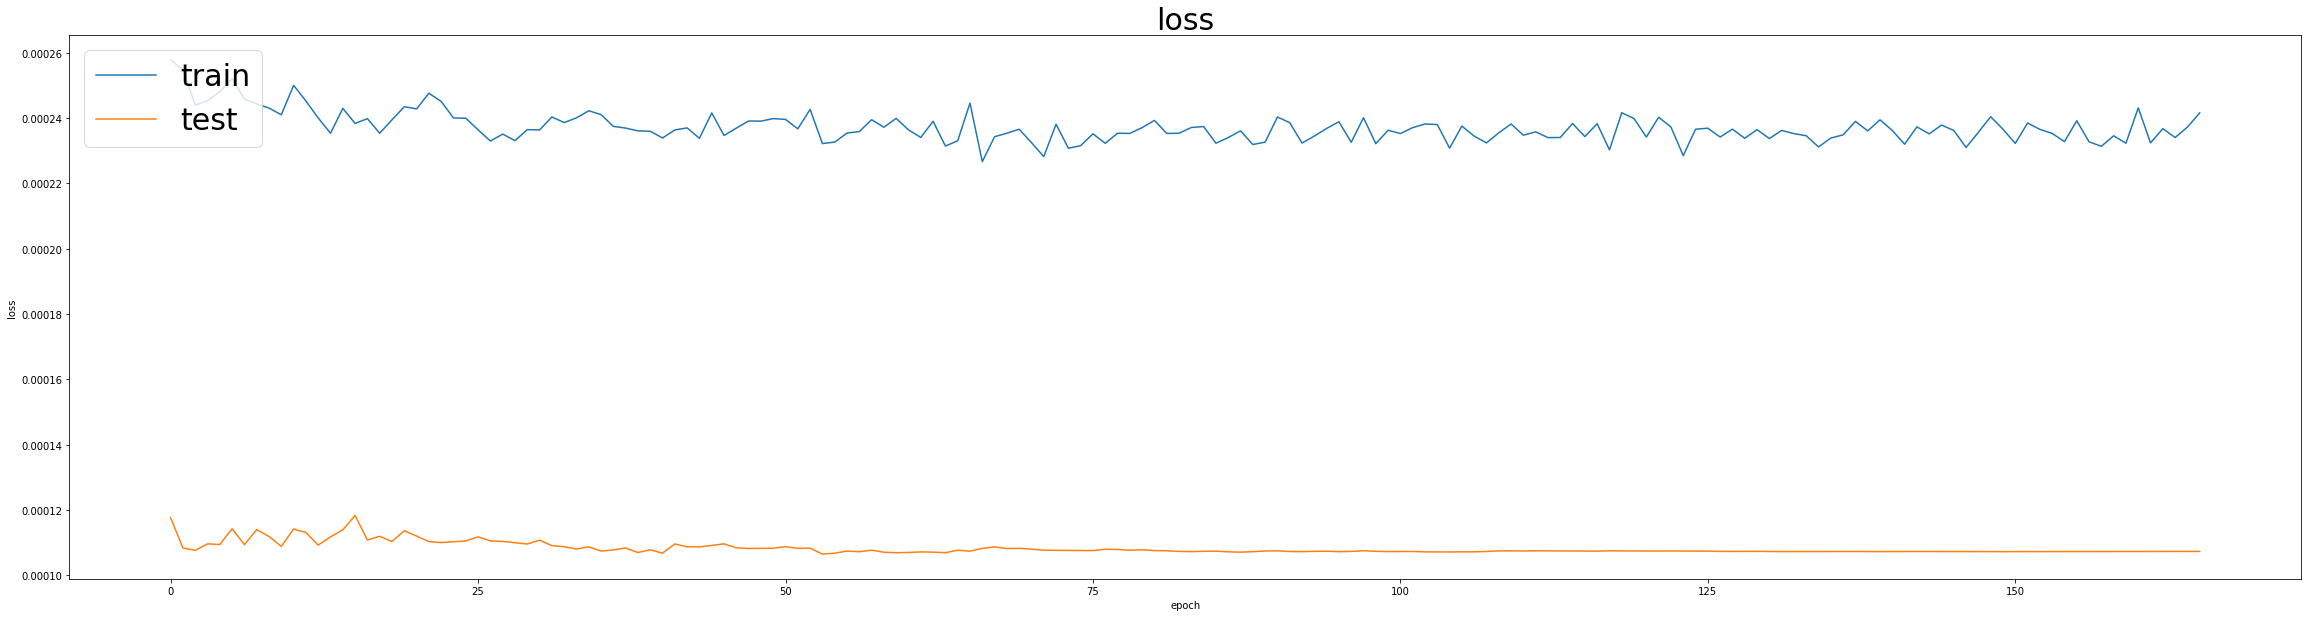

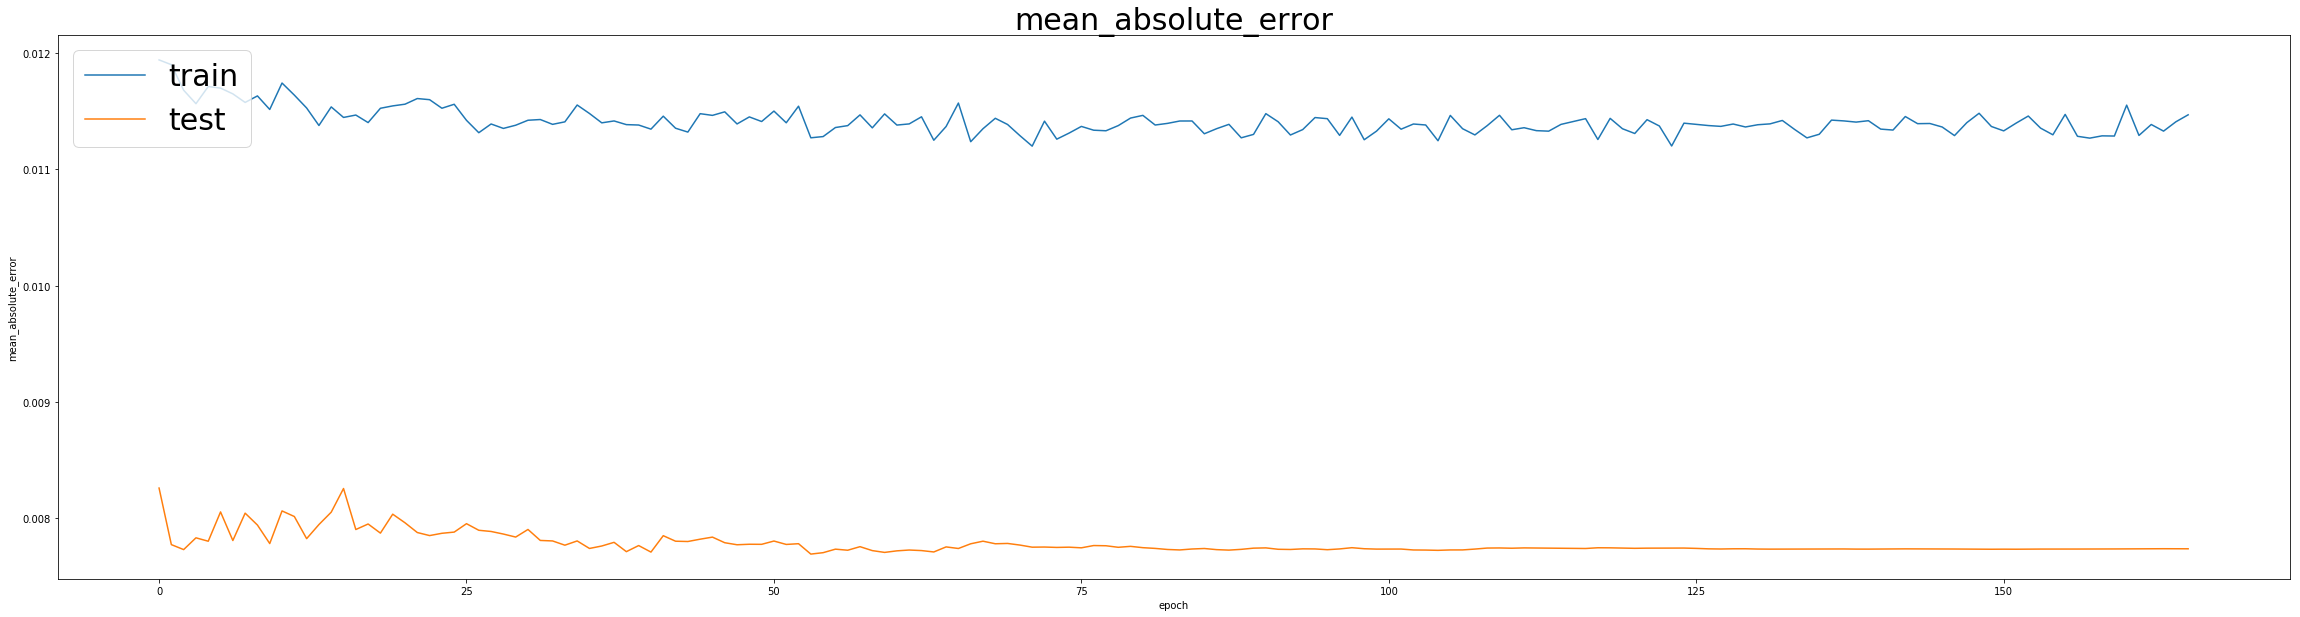

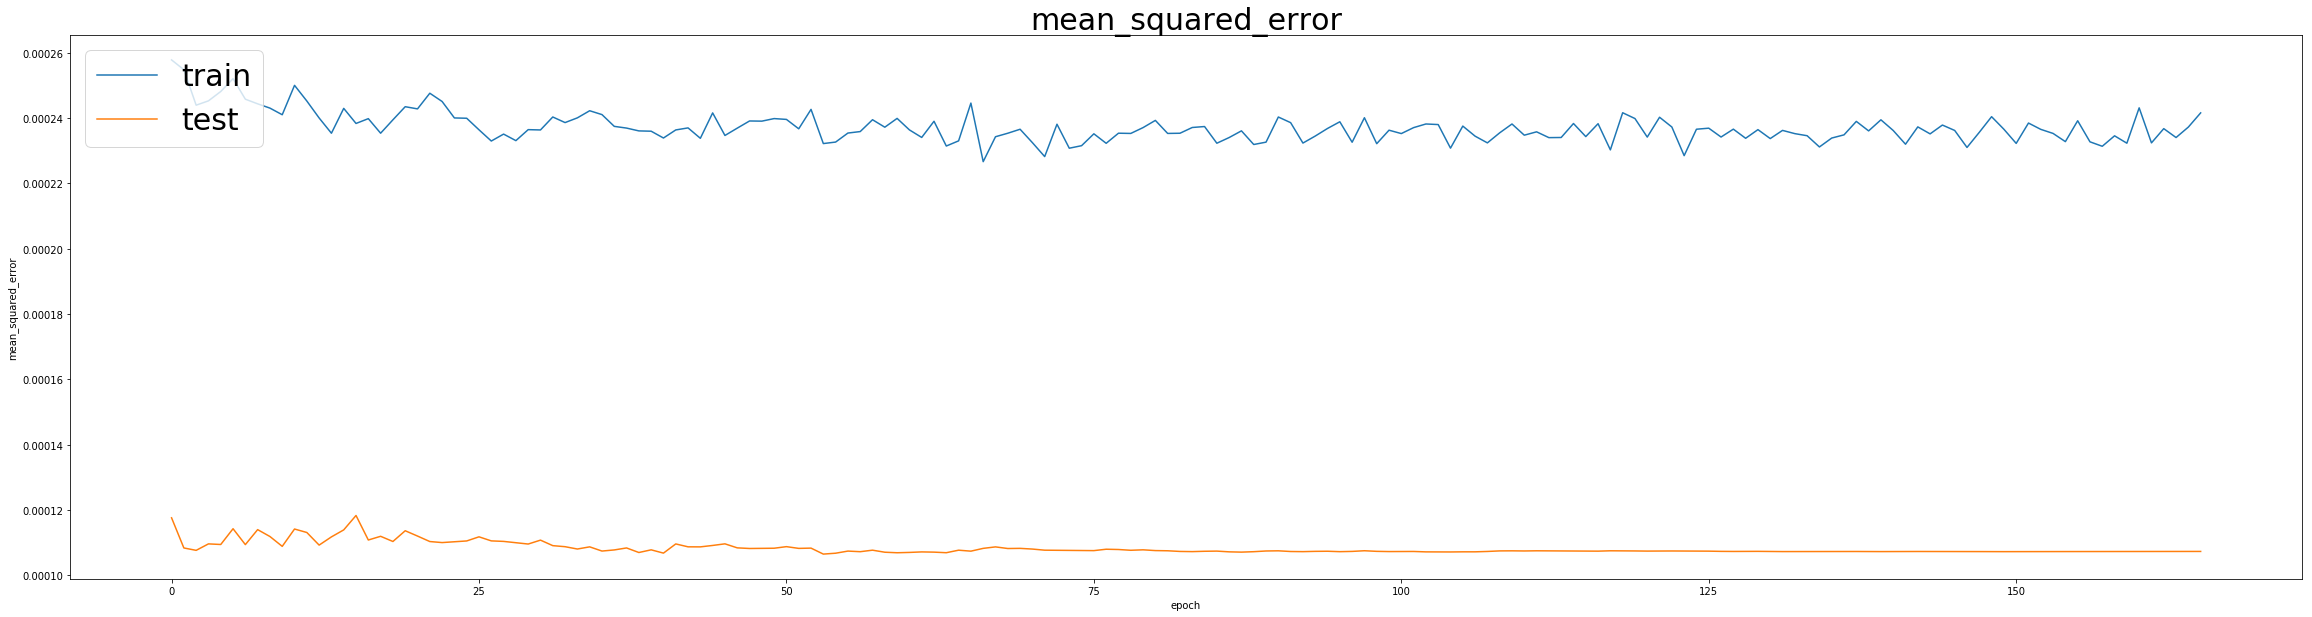

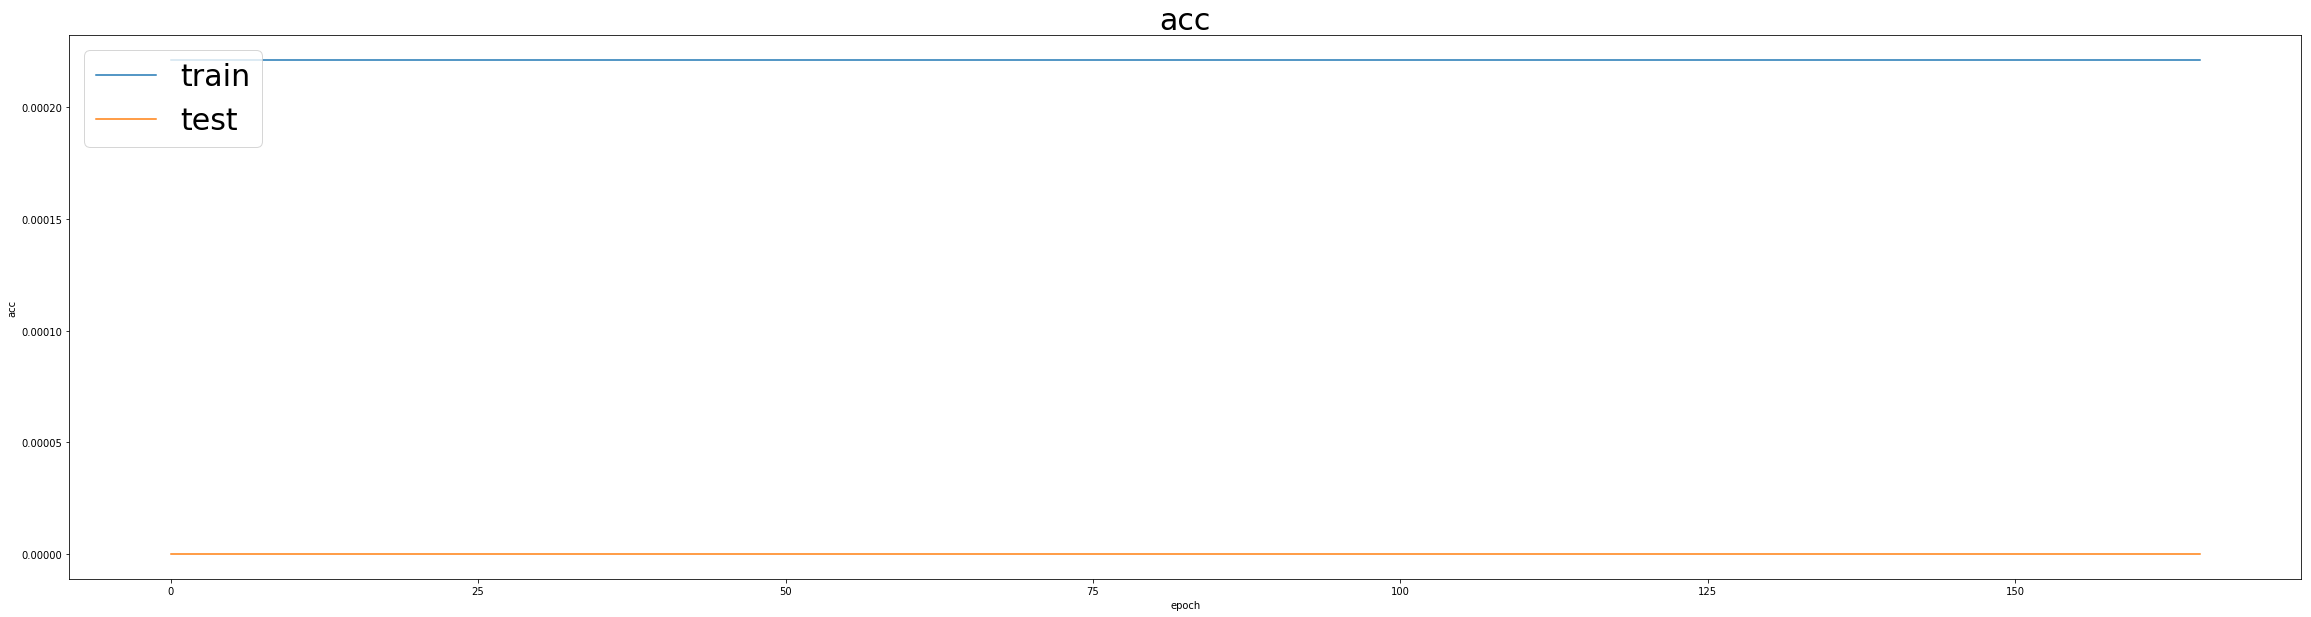

In [127]:
for error_metric in list(err_lr_decay_history.keys()):
    if 'val' not in error_metric:
        plt.figure(figsize=(40,10))
        plt.plot(err_lr_decay_history[error_metric]) # this is for train
        plt.plot(err_lr_decay_history['val_' + error_metric]) # this is for test
        plt.title(error_metric, fontsize=30)
        plt.ylabel(error_metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left', fontsize=30)
        plt.show()


The variance should have improved slightly. However, unless the mean absolute error is small enough, the model is not usable in practice. This is mainly due to only using the sample data for training and limiting epoch to a few hundreds.


## Check scaled predictions


In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [129]:
#simname = "500_epochs_40_lookback"
print(simname)
model.load_weights("model weights/"+simname+".better_weights.best.hdf5")

bm_with_lookback_5_epochs_500


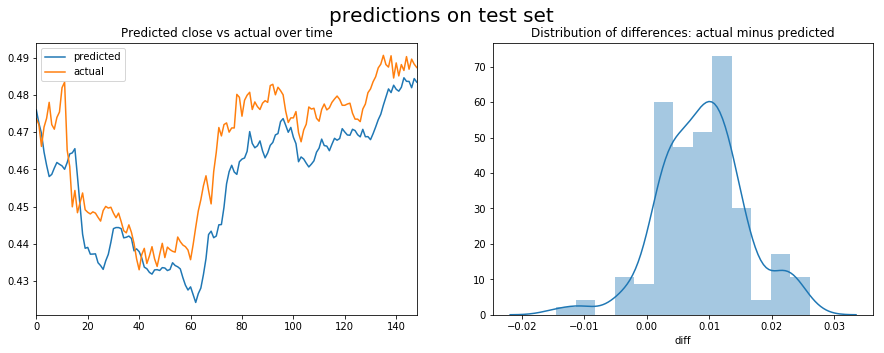

MSE scaled :  0.000126637351147
MAE scaled:  0.00961944420866


In [130]:
if not runLSTMBinary:
    # Benchmark
    model.load_weights("model weights/"+simname+".better_weights.best.hdf5")

    X_test_pred = model.predict(X_test) # predict on testset

    predictions = pd.DataFrame()
    predictions['predicted'] = pd.Series(np.reshape(X_test_pred, (X_test_pred.shape[0])))
    predictions['actual'] = y_test
    predictions = predictions.astype(float)


    fig, axarr = plt.subplots(1, 2, figsize=(15,5)) #1 row, 2 cols, x, y
    i_row, icol = 0,0
    fig.suptitle("predictions on test set", fontsize=20)
    predictions.plot(ax=axarr[icol])
    axarr[icol].set_title("Predicted close vs actual over time")

    icol +=1
    predictions['diff'] = predictions['actual'] - predictions['predicted']
    sns.distplot(predictions['diff'], ax=axarr[icol]);
    axarr[icol].set_title('Distribution of differences: actual minus predicted')
    plt.show()

    print("MSE scaled : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values))
    print("MAE scaled: ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values))
    #predictions['diff'].describe()

## Check unscaled predictions for regression


In [131]:
#unscale predictions and actuals
X_test_pred = model.predict(X_test)
X_test_pred_unscaled = y_scaler.inverse_transform(X_test_pred)
X_test_pred_unscaled = np.reshape(X_test_pred_unscaled, (X_test_pred_unscaled.shape[0]))

actual = y_scaler.inverse_transform(np.reshape(y_test, (y_test.shape[0], 1)))
actual = np.reshape(actual, (actual.shape[0]))

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(X_test_pred_unscaled)
predictions['close_bid'] = pd.Series(actual)


# get low and high bid from untransformed dataframe
p = df[-X_test_pred_unscaled.shape[0]:].copy()
predictions.index = p.index # get the date index  from the dataframe
predictions = predictions.astype(float)
predictions = predictions.merge(p[['low_bid', 'high_bid']], right_index=True, left_index=True)



C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'kind', 'space'
  s)


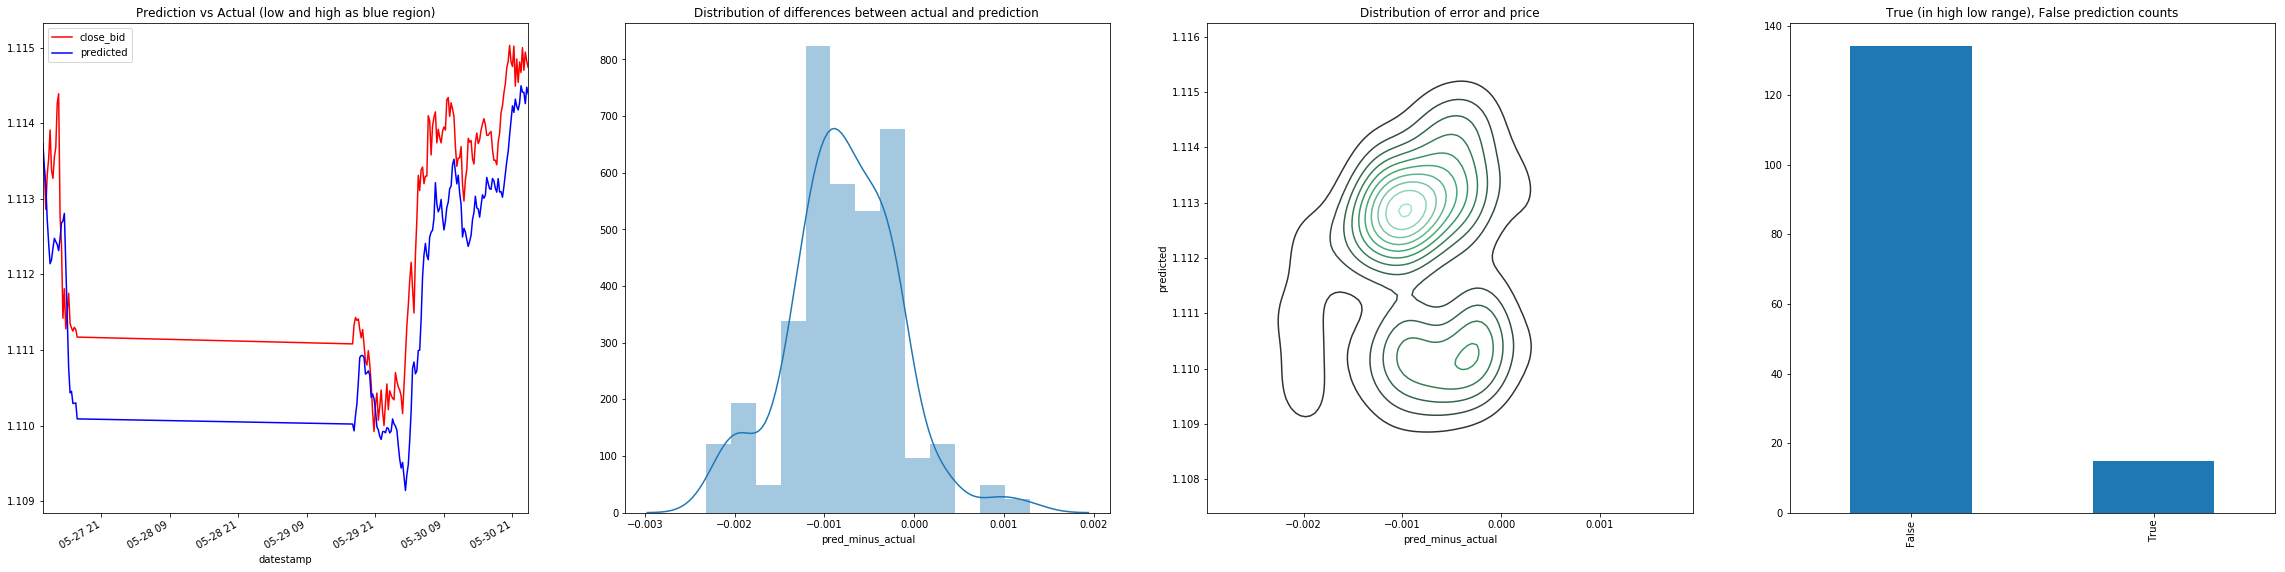

MSE unscaled :  9.97243585893e-07
MAE unscaled:  0.00085363292054


In [132]:
if not runLSTMBinary:
    fig, axarr = plt.subplots(1, 4, figsize=(5,10)) #1 row, 2 cols, x, y
    irow, icol = 0,0

    predictions.plot(x=predictions.index, y='close_bid', c='red', figsize=(40,10), ax=axarr[icol])
    predictions.plot(x=predictions.index, y='predicted', c='blue', figsize=(40,10), ax=axarr[icol])
    index = [str(item) for item in predictions.index]
    #plt.fill_between(x=predictions.index, y1='low_bid', y2='high_bid', data=predictions, alpha=0.4)
    axarr[icol].set_title('Prediction vs Actual (low and high as blue region)')

    icol += 1
    predictions['pred_minus_actual'] = predictions['predicted'] - predictions['close_bid']
    
    sns.distplot(predictions['pred_minus_actual'], ax=axarr[icol]);
    axarr[icol].set_title('Distribution of differences between actual and prediction ')
    #plt.savefig(simname+"__histogram__actual_minus_pred.jpg")

    icol += 1
    sns.kdeplot(predictions["pred_minus_actual"], predictions["predicted"], kind="kde", space=0, ax=axarr[icol])
    #sns.jointplot(predictions["diff"], predictions["predicted"], kind="kde", space=0, ax=axarr[icol]) # must be by itself
    axarr[icol].set_title('Distribution of error and price')
    #plt.savefig(simname+"__contour__error_v_price.jpg")


    icol +=1
    predictions['correct'] = (predictions['predicted'] <= predictions['high_bid']) & (predictions['predicted'] >= predictions['low_bid'])
    predictions.correct.value_counts().plot(kind="bar", ax=axarr[icol])
    axarr[icol].set_title("True (in high low range), False prediction counts")

    plt.show()

    print("MSE unscaled : ", mean_squared_error(predictions['predicted'].values, predictions['close_bid'].values))
    print("MAE unscaled: ", mean_absolute_error(predictions['predicted'].values, predictions['close_bid'].values))
    #predictions['pred_minus_actual'].describe()

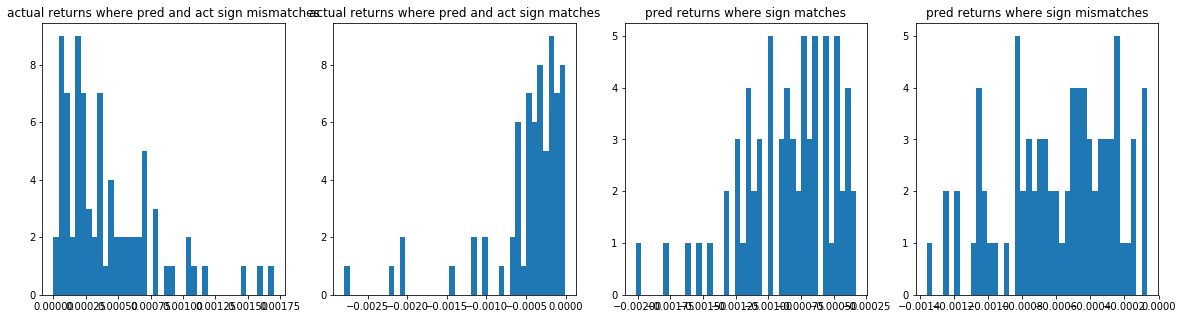

['mse train', 1.0473609e-06]
['mse test', 9.9724355e-07]
['mae train', 0.00069638382]
['mae test', 0.00085363293]
['how often sign of price change is same', 0.46308724832214765]
['if same sign, how often are actual returns better than 1 bp absolute in both directions', 86.956521739130437]
['if same sign, how often are actual returns better than predicted in both directions', 100.0]
['if not same sign, how often is actual worse than -1 bp return from predicted in both directions', 1.0]
['if not same sign, how often is actual worse than -1 bp return absolute in both directions', 0.82499999999999996]


In [133]:
if not runLSTMBinary:
    df_unscaled = df_scaler.inverse_transform(df_scaled)

    X_test_unscaled = df_scaler.inverse_transform(np.reshape(X_test[:,0,:], (X_test.shape[0], X_test.shape[2])))
    y_prev = X_test_unscaled[:,idx_close_bid]

    y_train_unscaled =  y_scaler.inverse_transform(np.reshape(y_train, (y_train.shape[0], 1)))
    y_train_unscaled = np.reshape(y_train_unscaled, (y_train_unscaled.shape[0]))

    y_test_unscaled =  y_scaler.inverse_transform(np.reshape(y_test, (y_test.shape[0], 1)))
    y_test_unscaled = np.reshape(y_test_unscaled, (y_test_unscaled.shape[0]))


    X_train_pred = model.predict(X_train)
    X_train_pred_unscaled = y_scaler.inverse_transform(X_train_pred)
    X_train_pred_unscaled = np.reshape(X_train_pred_unscaled, (X_train_pred_unscaled.shape[0]))

    #check_shape(df,y_train_unscaled, y_test_unscaled, X_train_pred_unscaled, X_test_pred_unscaled, y_prev)

    df_err = check_error_metrics(df
                        , y_train_unscaled, y_test_unscaled
                        , X_train_pred_unscaled, X_test_pred_unscaled
                        , y_prev)
    #idx_close_bid
    #X_test[:,0,idx_close_bid].shape

In [134]:
simname

'bm_with_lookback_5_epochs_500'

## check binary predictions and confusion matrix


In [135]:
if runLSTMBinary:
    from sklearn.metrics import confusion_matrix
    #check_shape(y_test, model.predict(X_test))
    y_pred_class = np.argmax(model.predict(X_test), axis=1)  # find position of largest argument
    y_test_class = np.argmax(y_test, axis=1)
    test_acc = 100 * np.sum(y_pred_class==y_test_class) / len(y_test)
    print("acc ", test_acc )
    confusion_matrix(y_pred_class, y_test_class)

Sim results:
- runing at 500 epochs converges a bit better. seems extra features need more time.

# Check logs and compare to previous simulations

In [136]:
log = True
initval=False
#sim_desc = "500 iterations, lookback 40"
#simname = "500_epoch_lookback_40"

In [137]:
list_stats=OrderedDict()

if log:
    #simname= "linear regression"
    #sim_desc = "1 row lookback"
    
    dict_err= OrderedDict(zip(df_err[0], df_err[1]))    
    list_stats=OrderedDict()    
    list_stats["simname"] = simname
    list_stats["sim_desc"] = sim_desc
    list_stats["MSE"] = dict_err["mse test"]
    list_stats["MAE"] = dict_err["mae test"]
    
    differences_described = predictions["pred_minus_actual"].describe()

    list_stats.update(OrderedDict(differences_described))
    list_stats.update(dict_err)
    
    results = pd.DataFrame([list_stats])
    #results.to_excel("log_results.xlsx")
    if os.path.isfile("log_results.xlsx"):
        log_results = pd.read_excel("log_results.xlsx")
        log_results.loc[len(log_results),:] = list_stats.values()
        log_results.to_excel("log_results.xlsx")
    #log_results


In [141]:
log_results = pd.read_excel("log_results.xlsx")
log_results = log_results.iloc[[1,5,20,21]].T

In [142]:
df_to_image(log_results, "report graphs/", "simlog")

0

In [143]:
log_results

,1,5,20,21
simname,bm_kaggle,kaggle param my dataset,bm_with_lookback_5_epochs_500,bm_with_lookback_5_epochs_500
sim_desc,kaggle bm has 200 epoch and batch size 500 and...,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n,\n kaggle params with my dataset\n
MSE,1.20446e-07,5.59631e-07,0.00170677,9.97244e-07
MAE,0.000278994,0.000571841,0.0412842,0.000853633
count,149,149,149,149
mean,9.99558e-05,-0.000226223,-0.0412842,-0.000790914
std,0.000333468,0.000715464,0.00154687,0.000611727
min,-0.00100839,-0.0018394,-0.04354,-0.0023185
25%,-0.00011158,-0.000689983,-0.0424299,-0.00111973
50%,0.000176191,-0.000272751,-0.04193,-0.000779629
